## NN Classification on previous datasets

In [1]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.utils import class_weight
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


In [2]:
def _prepare_binary_inputs(y_true, y_pred, threshold):
    """Utility to flatten sparse labels and extract positive-class probabilities."""
    y_true = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred = tf.cast(tf.convert_to_tensor(y_pred), tf.float32)
    if y_pred.shape.rank is not None:
        if y_pred.shape.rank > 1:
            if y_pred.shape[-1] == 1:
                y_pred = tf.squeeze(y_pred, axis=-1)
            else:
                y_pred = y_pred[..., 1]
        else:
            y_pred = tf.reshape(y_pred, [-1])
    else:
        rank = tf.rank(y_pred)
        y_pred = tf.cond(
            tf.equal(rank, 1),
            lambda: tf.reshape(y_pred, [-1]),
            lambda: tf.cond(
                tf.equal(tf.shape(y_pred)[-1], 1),
                lambda: tf.squeeze(y_pred, axis=-1),
                lambda: y_pred[..., 1]
            )
        )
    y_pred = tf.reshape(y_pred, [-1])
    y_pred_labels = tf.cast(y_pred >= threshold, tf.float32)
    return y_true, y_pred, y_pred_labels


class BinaryPrecision(tf.keras.metrics.Metric):
    """Binary precision that treats class 1 as the positive class."""
    def __init__(self, name='precision', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='true_positives', initializer='zeros')
        self.fp = self.add_weight(name='false_positives', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true, _, y_pred_labels = _prepare_binary_inputs(y_true, y_pred, self.threshold)
        if sample_weight is not None:
            sample_weight = tf.cast(tf.reshape(sample_weight, [-1]), tf.float32)
        else:
            sample_weight = tf.ones_like(y_true)
        tp = tf.reduce_sum(sample_weight * y_true * y_pred_labels)
        fp = tf.reduce_sum(sample_weight * (1.0 - y_true) * y_pred_labels)
        self.tp.assign_add(tp)
        self.fp.assign_add(fp)

    def result(self):
        denom = self.tp + self.fp
        return tf.where(tf.equal(denom, 0.0), 0.0, self.tp / denom)

    def reset_state(self):
        self.tp.assign(0.0)
        self.fp.assign(0.0)


class BinaryRecall(tf.keras.metrics.Metric):
    """Binary recall that treats class 1 as the positive class."""
    def __init__(self, name='recall', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='true_positives', initializer='zeros')
        self.fn = self.add_weight(name='false_negatives', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true, _, y_pred_labels = _prepare_binary_inputs(y_true, y_pred, self.threshold)
        if sample_weight is not None:
            sample_weight = tf.cast(tf.reshape(sample_weight, [-1]), tf.float32)
        else:
            sample_weight = tf.ones_like(y_true)
        tp = tf.reduce_sum(sample_weight * y_true * y_pred_labels)
        fn = tf.reduce_sum(sample_weight * y_true * (1.0 - y_pred_labels))
        self.tp.assign_add(tp)
        self.fn.assign_add(fn)

    def result(self):
        denom = self.tp + self.fn
        return tf.where(tf.equal(denom, 0.0), 0.0, self.tp / denom)

    def reset_state(self):
        self.tp.assign(0.0)
        self.fn.assign(0.0)


class BinaryF1Score(tf.keras.metrics.Metric):
    """Binary F1 score metric that treats class 1 as the positive class."""
    def __init__(self, name='f1', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.precision_metric = BinaryPrecision(name='precision_component', threshold=threshold)
        self.recall_metric = BinaryRecall(name='recall_component', threshold=threshold)

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision_metric.update_state(y_true, y_pred, sample_weight)
        self.recall_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision_metric.result()
        recall = self.recall_metric.result()
        denom = precision + recall
        return tf.where(tf.equal(denom, 0.0), 0.0, 2.0 * precision * recall / denom)

    def reset_state(self):
        self.precision_metric.reset_state()
        self.recall_metric.reset_state()

In [3]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True, show_confusion_matrix=True):
    val_losses = hist.history['val_loss']
    min_val_loss = float(np.min(val_losses))
    min_val_epoch = int(np.argmin(val_losses)) + 1

    train_precision = hist.history.get('precision')
    val_precision = hist.history.get('val_precision')
    train_recall = hist.history.get('recall')
    val_recall = hist.history.get('val_recall')
    train_f1 = hist.history.get('f1')
    val_f1 = hist.history.get('val_f1')
    train_accuracy = hist.history.get('accuracy')
    val_accuracy = hist.history.get('val_accuracy')

    required = [train_precision, val_precision, train_recall, val_recall, train_f1, val_f1, train_accuracy, val_accuracy]
    if any(metric_series is None for metric_series in required):
        raise ValueError("Expected precision, recall, f1, and accuracy metrics in training history. Ensure the model is compiled with these metrics.")

    best_val_recall = float(np.max(val_recall))
    best_val_recall_epoch = int(np.argmax(val_recall)) + 1
    best_val_precision = float(np.max(val_precision))
    best_val_precision_epoch = int(np.argmax(val_precision)) + 1
    best_val_f1 = float(np.max(val_f1))
    best_val_f1_epoch = int(np.argmax(val_f1)) + 1
    best_val_accuracy = float(np.max(val_accuracy))
    best_val_accuracy_epoch = int(np.argmax(val_accuracy)) + 1

    val_recall_at_min_loss = float(val_recall[min_val_epoch - 1])
    val_precision_at_min_loss = float(val_precision[min_val_epoch - 1])
    val_f1_at_min_loss = float(val_f1[min_val_epoch - 1])
    val_accuracy_at_min_loss = float(val_accuracy[min_val_epoch - 1])

    epochs = range(1, len(val_losses) + 1)

    fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, val_losses, label='val loss')
    axs[0].scatter(min_val_epoch, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Recall Plot ---
    axs[1].plot(epochs, train_recall, label='train recall')
    axs[1].plot(epochs, val_recall, label='val recall')
    axs[1].scatter(best_val_recall_epoch, best_val_recall, color='green', marker='x', s=50, label='max val recall')
    axs[1].set_title(f'{title} - Recall')
    axs[1].set_ylabel('Recall')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    # --- Precision / Accuracy / F1 Plot ---
    axs[2].plot(epochs, train_precision, label='train precision', linestyle='--')
    axs[2].plot(epochs, val_precision, label='val precision')
    axs[2].plot(epochs, train_f1, label='train f1', linestyle='--')
    axs[2].plot(epochs, val_f1, label='val f1')
    axs[2].plot(epochs, train_accuracy, label='train accuracy', linestyle='--')
    axs[2].plot(epochs, val_accuracy, label='val accuracy')
    axs[2].set_title(f'{title} - Precision / F1 / Accuracy')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Score')
    axs[2].legend(ncol=2)
    axs[2].grid(True)
    axs[2].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if show_confusion_matrix:
        print("\nConfusion Matrix (Validation Set)")
        print("----------------------------------")
        try:
            val_probs = model.predict(X_val)
            if val_probs.ndim == 1 or val_probs.shape[-1] == 1:
                val_preds = (val_probs >= 0.5).astype(int).ravel()
            else:
                val_preds = np.argmax(val_probs, axis=1)
            cm = confusion_matrix(y_true=y_val, y_pred=val_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(cmap=plt.cm.Blues)
            disp.ax_.set_xlabel('Predicted Label')
            disp.ax_.set_ylabel('True Label')
            disp.ax_.set_title(f'{title} - Confusion Matrix (Validation)')
            plt.show()
        except Exception as ex:
            print("Confusion matrix could not be generated:")
            print(ex)

    if verbose:
        print(f"Final Training Metrics -> Loss: {hist.history['loss'][-1]:.4f}, Precision: {train_precision[-1]:.4f}, Recall: {train_recall[-1]:.4f}, F1: {train_f1[-1]:.4f}, Accuracy: {train_accuracy[-1]:.4f}")
        print(f"Final Validation Metrics -> Loss: {val_losses[-1]:.4f}, Precision: {val_precision[-1]:.4f}, Recall: {val_recall[-1]:.4f}, F1: {val_f1[-1]:.4f}, Accuracy: {val_accuracy[-1]:.4f}")
        print(f"Minimum Validation Loss: {min_val_loss:.4f} (Epoch {min_val_epoch})")
        print(f"Validation Metrics @ Min Loss -> Precision: {val_precision_at_min_loss:.4f}, Recall: {val_recall_at_min_loss:.4f}, F1: {val_f1_at_min_loss:.4f}, Accuracy: {val_accuracy_at_min_loss:.4f}")
        print(f"Best Validation Recall: {best_val_recall:.4f} (Epoch {best_val_recall_epoch})")
        print(f"Best Validation Precision: {best_val_precision:.4f} (Epoch {best_val_precision_epoch})")
        print(f"Best Validation F1: {best_val_f1:.4f} (Epoch {best_val_f1_epoch})")
        print(f"Best Validation Accuracy: {best_val_accuracy:.4f} (Epoch {best_val_accuracy_epoch})")

    results[title] = (best_val_recall, best_val_recall_epoch)

    return {
        'min_val_loss': min_val_loss,
        'min_val_epoch': min_val_epoch,
        'val_precision_at_min_loss': val_precision_at_min_loss,
        'val_recall_at_min_loss': val_recall_at_min_loss,
        'val_f1_at_min_loss': val_f1_at_min_loss,
        'val_accuracy_at_min_loss': val_accuracy_at_min_loss,
        'best_val_precision': best_val_precision,
        'best_val_precision_epoch': best_val_precision_epoch,
        'best_val_recall': best_val_recall,
        'best_val_recall_epoch': best_val_recall_epoch,
        'best_val_f1': best_val_f1,
        'best_val_f1_epoch': best_val_f1_epoch,
        'best_val_accuracy': best_val_accuracy,
        'best_val_accuracy_epoch': best_val_accuracy_epoch
    }

results = {}

In [4]:
def print_results():
    for title, (recall_val, epoch) in sorted(results.items(),
                                             key=lambda kv: kv[1][0],
                                             reverse=True):
        print(f"{title:<40}\tBest Val Recall: {recall_val:.4f} (Epoch {epoch})")

In [5]:
# Uses globals X_train,y_train,X_val,y_val
def train_and_test(model,
                   epochs        = 500,                   # Just needs to be bigger than early stopping point
                   lr_schedule   = 1e-3,                  # Adam default
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 128,
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")

    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer

    metrics_to_track = [
        BinaryPrecision(name='precision'),
        BinaryRecall(name='recall'),
        BinaryF1Score(name='f1'),
        'accuracy'
    ]

    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=metrics_to_track
                 )

    early_stop = EarlyStopping(
        monitor='val_recall',
        patience=patience,
        min_delta=min_delta,
        mode='max',
        restore_best_weights=True,
        verbose=verbose
    )

    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )

    class_weights_dict = dict(enumerate(class_weights))

    if use_early_stopping:
        cbs = [early_stop] + callbacks
    else:
        cbs = callbacks

    start = time.time()

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        class_weight=class_weights_dict,
                        callbacks=cbs,
                        verbose=verbose
                       )

    curve_summary = plot_learning_curves(history, title=title)

    final_train_precision = float(history.history['precision'][-1])
    final_train_recall = float(history.history['recall'][-1])
    final_train_f1 = float(history.history['f1'][-1])
    final_train_accuracy = float(history.history['accuracy'][-1])

    final_val_precision = float(history.history['val_precision'][-1])
    final_val_recall = float(history.history['val_recall'][-1])
    final_val_f1 = float(history.history['val_f1'][-1])
    final_val_accuracy = float(history.history['val_accuracy'][-1])

    eval_results = model.evaluate(X_test, y_test, verbose=0)
    test_loss = float(eval_results[0])
    test_precision = float(eval_results[1])
    test_recall = float(eval_results[2])
    test_f1 = float(eval_results[3])
    test_accuracy = float(eval_results[4])

    print(f"\nTest Metrics -> Loss: {test_loss:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}, Accuracy: {test_accuracy:.4f}")

    validation_test_gap_recall = abs(curve_summary['best_val_recall'] - test_recall)
    validation_test_gap_precision = abs(curve_summary['best_val_precision'] - test_precision)
    validation_test_gap_f1 = abs(curve_summary['best_val_f1'] - test_f1)
    validation_test_gap_accuracy = abs(curve_summary['best_val_accuracy'] - test_accuracy)

    print(f"\nValidation-Test Gap -> Recall: {validation_test_gap_recall:.6f}, Precision: {validation_test_gap_precision:.6f}, F1: {validation_test_gap_f1:.6f}, Accuracy: {validation_test_gap_accuracy:.6f}")

    end = time.time()
    print(f"\nExecution Time: " + format_hms(end - start))

    metrics = {
        **curve_summary,
        'final_train_precision': final_train_precision,
        'final_train_recall': final_train_recall,
        'final_train_f1': final_train_f1,
        'final_train_accuracy': final_train_accuracy,
        'final_val_precision': final_val_precision,
        'final_val_recall': final_val_recall,
        'final_val_f1': final_val_f1,
        'final_val_accuracy': final_val_accuracy,
        'test_loss': test_loss,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'test_accuracy': test_accuracy,
        'validation_test_gap_recall': validation_test_gap_recall,
        'validation_test_gap_precision': validation_test_gap_precision,
        'validation_test_gap_f1': validation_test_gap_f1,
        'validation_test_gap_accuracy': validation_test_gap_accuracy
    }

    if return_history:
        return history, metrics

    return metrics

In [6]:
def encoding(df_or_series, target=None, cat_cols: list = None, one_hot: bool = False):
    """
    Encodes categorical columns in a DataFrame or a single pandas Series.

    Args:
        df_or_series: DataFrame or Series to encode.
        target: Column name (or iterable of names) to leave untouched when encoding a DataFrame.
        cat_cols: List of columns to encode (only used if input is DataFrame).
        one_hot: If True, use one-hot encoding for DataFrame input.

    Returns:
        If input is DataFrame: encoded DataFrame (and optionally mappings for label encoding).
        If input is Series: encoded Series.
    """
    # Normalize target parameter into a set for quick exclusion checks
    if target is None:
        target_cols = set()
    elif isinstance(target, (list, tuple, set)):
        target_cols = set(target)
    else:
        target_cols = {target}

    if isinstance(df_or_series, pd.Series):
        uniques = df_or_series.dropna().unique().tolist()
        mapping = {cat: code for code, cat in enumerate(uniques)}
        encoded = df_or_series.map(mapping).astype("int64")
        return encoded

    elif isinstance(df_or_series, pd.DataFrame):
        df_encoded = df_or_series.copy()

        if one_hot:
            if cat_cols is None:
                cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
            cat_cols = [c for c in cat_cols if c not in target_cols]
            return pd.get_dummies(df_encoded, columns=cat_cols, drop_first=True)

        if cat_cols is None:
            cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
        cat_cols = [c for c in cat_cols if c not in target_cols]

        mappings = {}
        for col in cat_cols:
            uniques = df_encoded[col].dropna().unique().tolist()
            mapping = {cat: code for code, cat in enumerate(uniques)}
            mappings[col] = mapping
            df_encoded[col] = df_encoded[col].map(mapping).astype("int64")

        return df_encoded

    else:
        raise ValueError("Input must be a pandas DataFrame or Series.")

In [7]:
def split_data(df: pd.DataFrame, 
                        target_col: str = None, 
                        one_hot: bool = False, 
                        test_size: float = 0.2, 
                        random_state: int = 0, 
                        scaling: str = 'norm'
                        ):
    """
    Loads data, encodes categorical features, splits into train/test, and scales features.

    Args:
        file_path: Path to CSV file.
        target_col: Name of target column. If None, uses last column.
        test_size: Fraction for test split.
        random_state: Random seed.
        scaling: 'norm' (MinMax), 'reg' (Standard), or None.

    Returns:
        X_train, X_test, y_train, y_test, df, mappings
    """

    # Select target
    if target_col is None:
        target_col = df.columns[-1]
    X = df.drop(columns=[target_col])
    y = df[target_col]
        
    # stratified 60/20/20 split (train/val/test)
    test_size = 0.20
    val_size = 0.20  # of the whole dataset

    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_seed, stratify=y
    )
    val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
    )

    # Reset indices
    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Scaling
    if scaling == 'reg':
        scaler = StandardScaler()
    elif scaling == 'norm':
        scaler = MinMaxScaler()
    else:
        scaler = None

    if scaler is not None:
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    # quick sanity checks
    def show_counts(name, y_arr):
        c = Counter(y_arr)
        total = sum(c.values())
        print(f"{name}: total={total}, per-class={dict(c)}")

    print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
    show_counts("train", y_train)
    show_counts("val  ", y_val)
    show_counts("test ", y_test)

    # you now have: X_train, y_train, X_val, y_val, X_test, y_test

    # Looks like integer encoded multi-class, let's check and define the global n_classes

    labels = np.unique(y_train)

    n_classes = len(labels)

    print("class labels:",labels)

    return X_train, X_val, X_test, y_train, y_val, y_test, df, n_classes


In [8]:
# Load the cleaned datasets
df_car = pd.read_csv(r'C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\data\carclaims_cleaned.csv')

# Encode the datasets
df_car_oh = encoding(df_car, one_hot=True)

# Regularized One-hot data
X_train, X_val, X_test, y_train, y_val, y_test, df_car, n_classes = split_data(df_car_oh, target_col='FraudFound', scaling='reg')

shapes: X_train (9060, 112) X_val (3020, 112) X_test (3020, 112)
train: total=9060, per-class={0: 8524, 1: 536}
val  : total=3020, per-class={0: 2842, 1: 178}
test : total=3020, per-class={0: 2842, 1: 178}
class labels: [0 1]


In [10]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained. 

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )

In [11]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         7,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,378 (36.63 KB)

 Trainable params: 9,378 (36.63 KB)

 Non-trainable params: 0 (0.00 B)

### Activation Function testing


Activation Function: relu



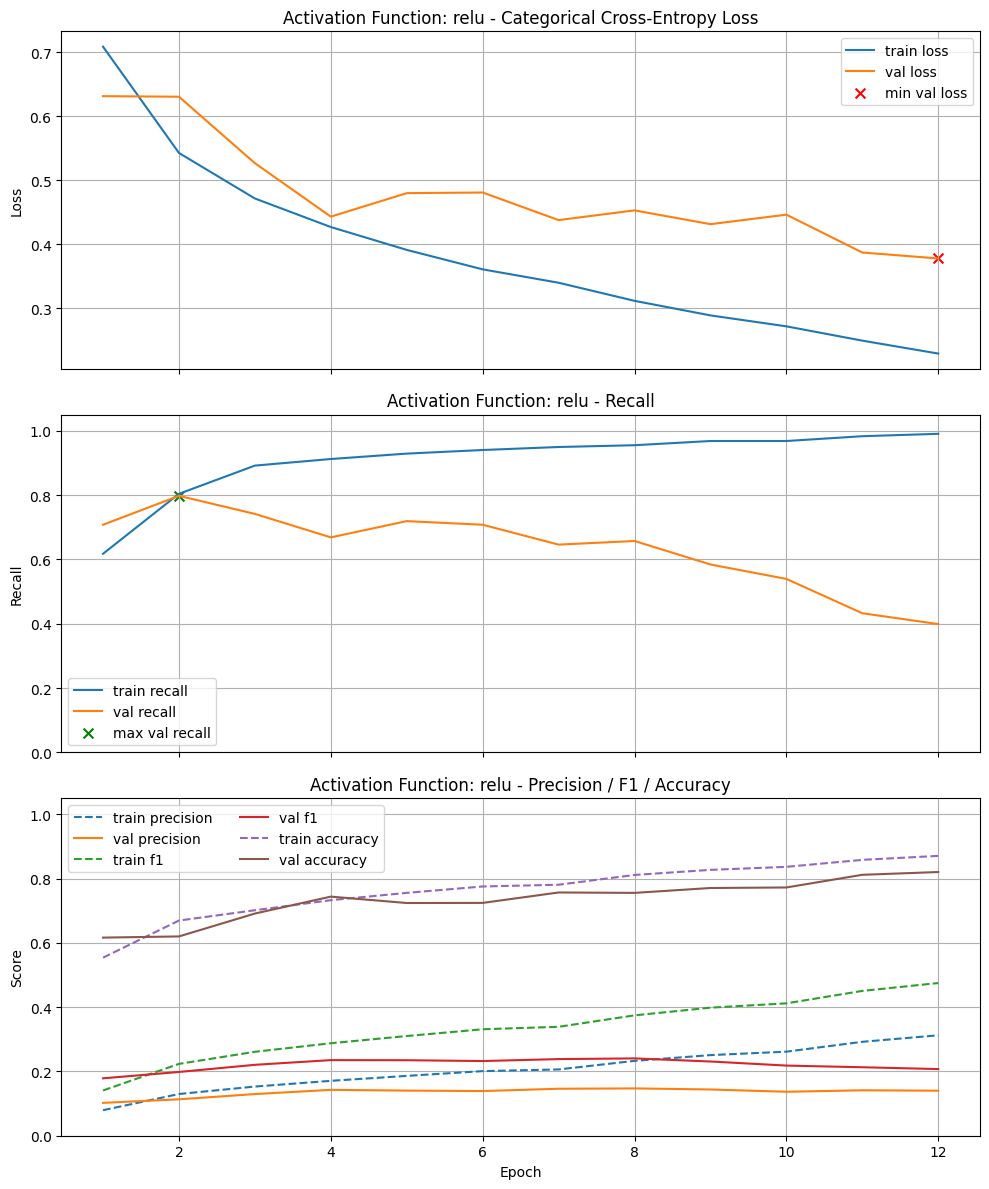


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step


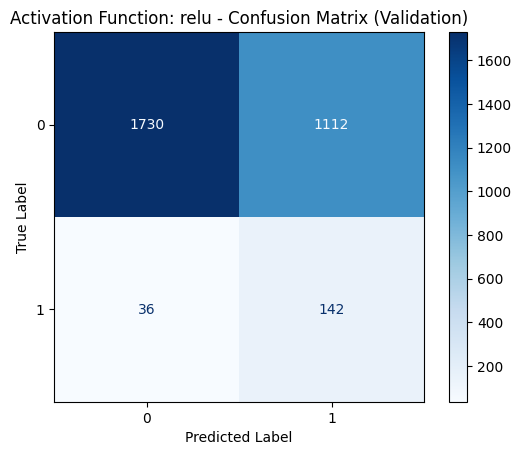

Final Training Metrics -> Loss: 0.2292, Precision: 0.3124, Recall: 0.9907, F1: 0.4750, Accuracy: 0.8704
Final Validation Metrics -> Loss: 0.3778, Precision: 0.1400, Recall: 0.3989, F1: 0.2073, Accuracy: 0.8202
Minimum Validation Loss: 0.3778 (Epoch 12)
Validation Metrics @ Min Loss -> Precision: 0.1400, Recall: 0.3989, F1: 0.2073, Accuracy: 0.8202
Best Validation Recall: 0.7978 (Epoch 2)
Best Validation Precision: 0.1472 (Epoch 8)
Best Validation F1: 0.2405 (Epoch 8)
Best Validation Accuracy: 0.8202 (Epoch 12)

Test Metrics -> Loss: 0.6287, Precision: 0.1203, Recall: 0.8258, F1: 0.2100, Accuracy: 0.6338

Validation-Test Gap -> Recall: 0.028090, Precision: 0.026875, F1: 0.030493, Accuracy: 0.186424

Execution Time: 00:00:04

Activation Function: tanh


Test Metrics -> Loss: 0.6287, Precision: 0.1203, Recall: 0.8258, F1: 0.2100, Accuracy: 0.6338

Validation-Test Gap -> Recall: 0.028090, Precision: 0.026875, F1: 0.030493, Accuracy: 0.186424

Execution Time: 00:00:04

Activation Function: 

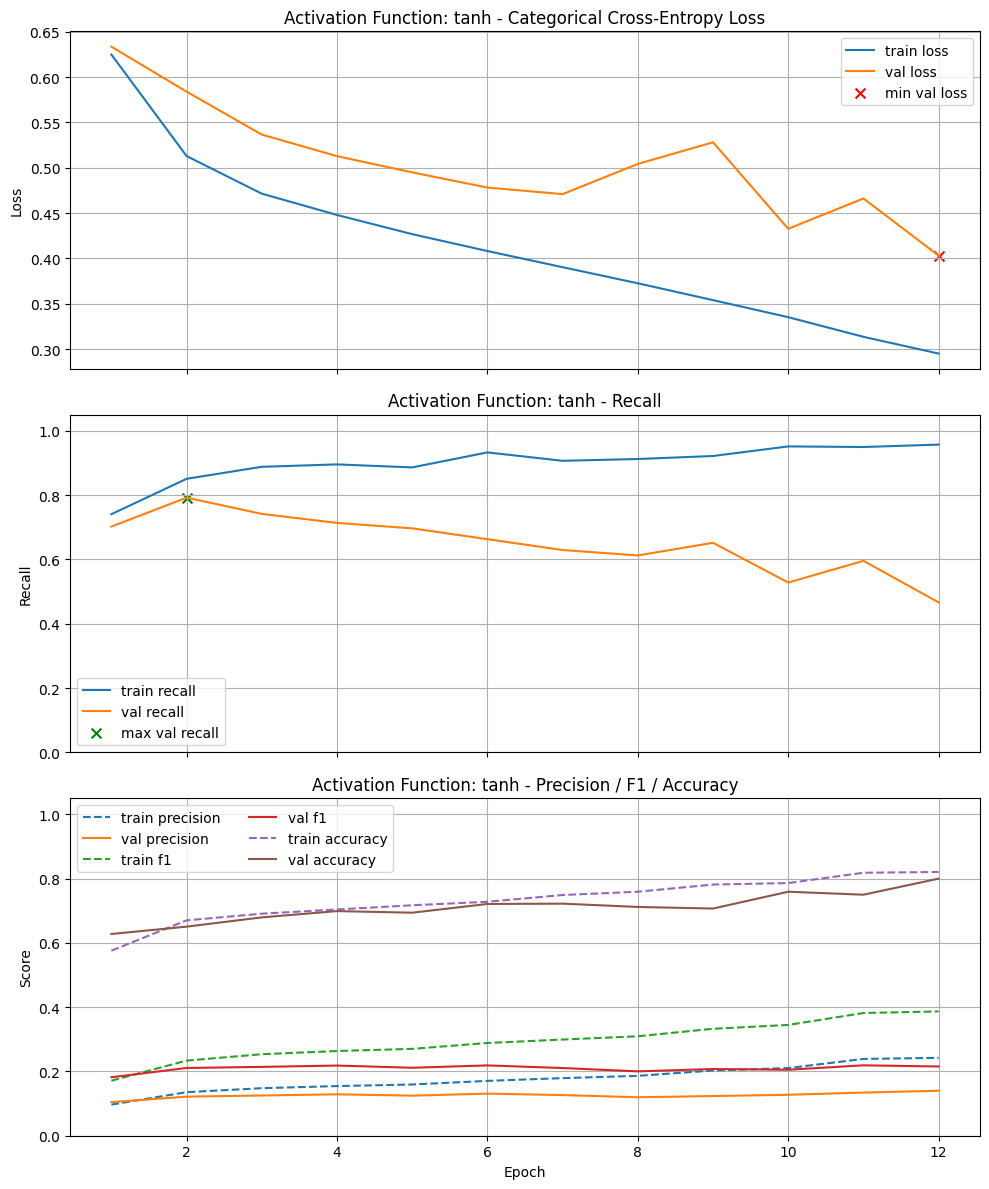


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step


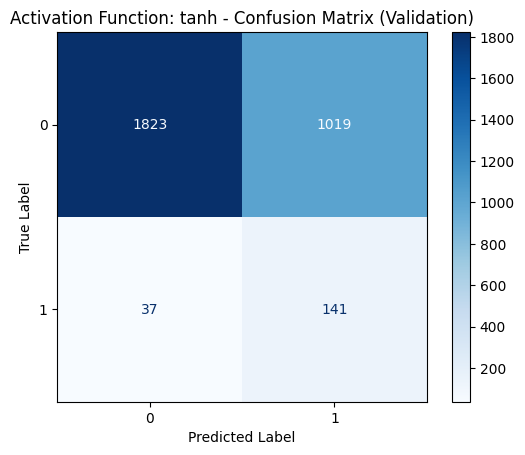

Final Training Metrics -> Loss: 0.2951, Precision: 0.2422, Recall: 0.9571, F1: 0.3866, Accuracy: 0.8203
Final Validation Metrics -> Loss: 0.4032, Precision: 0.1400, Recall: 0.4663, F1: 0.2153, Accuracy: 0.7997
Minimum Validation Loss: 0.4032 (Epoch 12)
Validation Metrics @ Min Loss -> Precision: 0.1400, Recall: 0.4663, F1: 0.2153, Accuracy: 0.7997
Best Validation Recall: 0.7921 (Epoch 2)
Best Validation Precision: 0.1400 (Epoch 12)
Best Validation F1: 0.2190 (Epoch 11)
Best Validation Accuracy: 0.7997 (Epoch 12)

Test Metrics -> Loss: 0.5880, Precision: 0.1259, Recall: 0.8202, F1: 0.2182, Accuracy: 0.6536

Validation-Test Gap -> Recall: 0.028090, Precision: 0.014104, F1: 0.000772, Accuracy: 0.146026

Execution Time: 00:00:04

Activation Function: sigmoid


Test Metrics -> Loss: 0.5880, Precision: 0.1259, Recall: 0.8202, F1: 0.2182, Accuracy: 0.6536

Validation-Test Gap -> Recall: 0.028090, Precision: 0.014104, F1: 0.000772, Accuracy: 0.146026

Execution Time: 00:00:04

Activation Funct

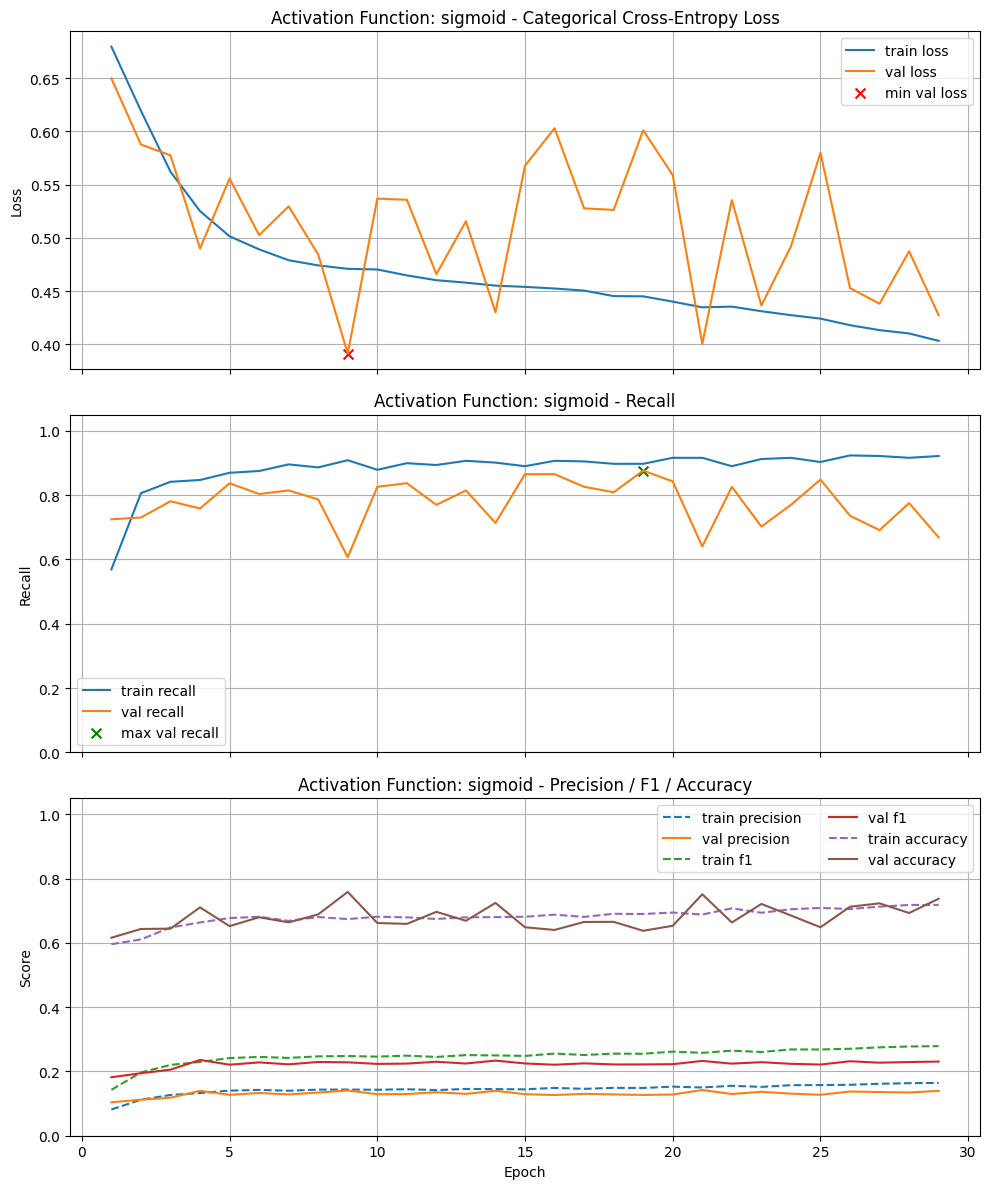


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step


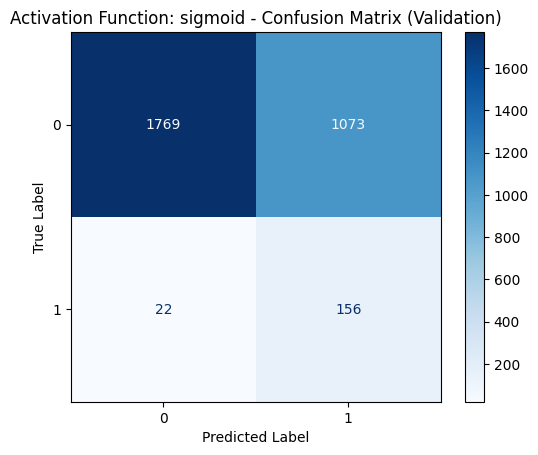

Final Training Metrics -> Loss: 0.4033, Precision: 0.1642, Recall: 0.9216, F1: 0.2788, Accuracy: 0.7179
Final Validation Metrics -> Loss: 0.4274, Precision: 0.1393, Recall: 0.6685, F1: 0.2306, Accuracy: 0.7371
Minimum Validation Loss: 0.3913 (Epoch 9)
Validation Metrics @ Min Loss -> Precision: 0.1406, Recall: 0.6067, F1: 0.2283, Accuracy: 0.7583
Best Validation Recall: 0.8764 (Epoch 19)
Best Validation Precision: 0.1421 (Epoch 21)
Best Validation F1: 0.2358 (Epoch 4)
Best Validation Accuracy: 0.7583 (Epoch 9)

Test Metrics -> Loss: 0.6020, Precision: 0.1290, Recall: 0.8933, F1: 0.2254, Accuracy: 0.6381

Validation-Test Gap -> Recall: 0.016854, Precision: 0.013191, F1: 0.010436, Accuracy: 0.120199

Execution Time: 00:00:06

Test Metrics -> Loss: 0.6020, Precision: 0.1290, Recall: 0.8933, F1: 0.2254, Accuracy: 0.6381

Validation-Test Gap -> Recall: 0.016854, Precision: 0.013191, F1: 0.010436, Accuracy: 0.120199

Execution Time: 00:00:06


In [12]:
# Your code here. Add as many cells as you need.
activation = ['relu', 'tanh', 'sigmoid']

results_1 = pd.DataFrame(columns=[
    'Title',
    'Best Val Recall',
    'Best Val Precision',
    'Best Val F1',
    'Best Val Accuracy',
    'Min Val Loss',
    'Val Recall @ Min Loss',
    'Val Precision @ Min Loss',
    'Val F1 @ Min Loss',
    'Test Recall',
    'Test Precision',
    'Test F1',
    'Test Accuracy'
], index=[0,1,2])

for i, func in enumerate(activation):
    model = build_model(X_train.shape[1], [ (64, func, 0.0, 0.0), (32, func, 0.0, 0.0)], n_classes)
    history, metrics = train_and_test(model, title=f"Activation Function: {func}", verbose=0, return_history = True)
    results_1.loc[i] = [
        f"Activation Function: {func}",
        metrics['best_val_recall'],
        metrics['best_val_precision'],
        metrics['best_val_f1'],
        metrics['best_val_accuracy'],
        metrics['min_val_loss'],
        metrics['val_recall_at_min_loss'],
        metrics['val_precision_at_min_loss'],
        metrics['val_f1_at_min_loss'],
        metrics['test_recall'],
        metrics['test_precision'],
        metrics['test_f1'],
        metrics['test_accuracy']
    ]

In [13]:
results_1

,Title,Best Val Recall,Best Val Precision,Best Val F1,Best Val Accuracy,Min Val Loss,Val Recall @ Min Loss,Val Precision @ Min Loss,Val F1 @ Min Loss,Test Recall,Test Precision,Test F1,Test Accuracy
0,Activation Function: relu,0.797753,0.14717,0.240493,0.820199,0.377783,0.398876,0.140039,0.207299,0.825843,0.120295,0.21,0.633775
1,Activation Function: tanh,0.792135,0.139966,0.219008,0.799669,0.403174,0.466292,0.139966,0.215305,0.820225,0.125862,0.218236,0.653642
2,Activation Function: sigmoid,0.876405,0.142145,0.235808,0.758278,0.391348,0.606742,0.140625,0.22833,0.893258,0.128954,0.225372,0.638079


### Learning Rate Testing


Learning Rate: 0.001



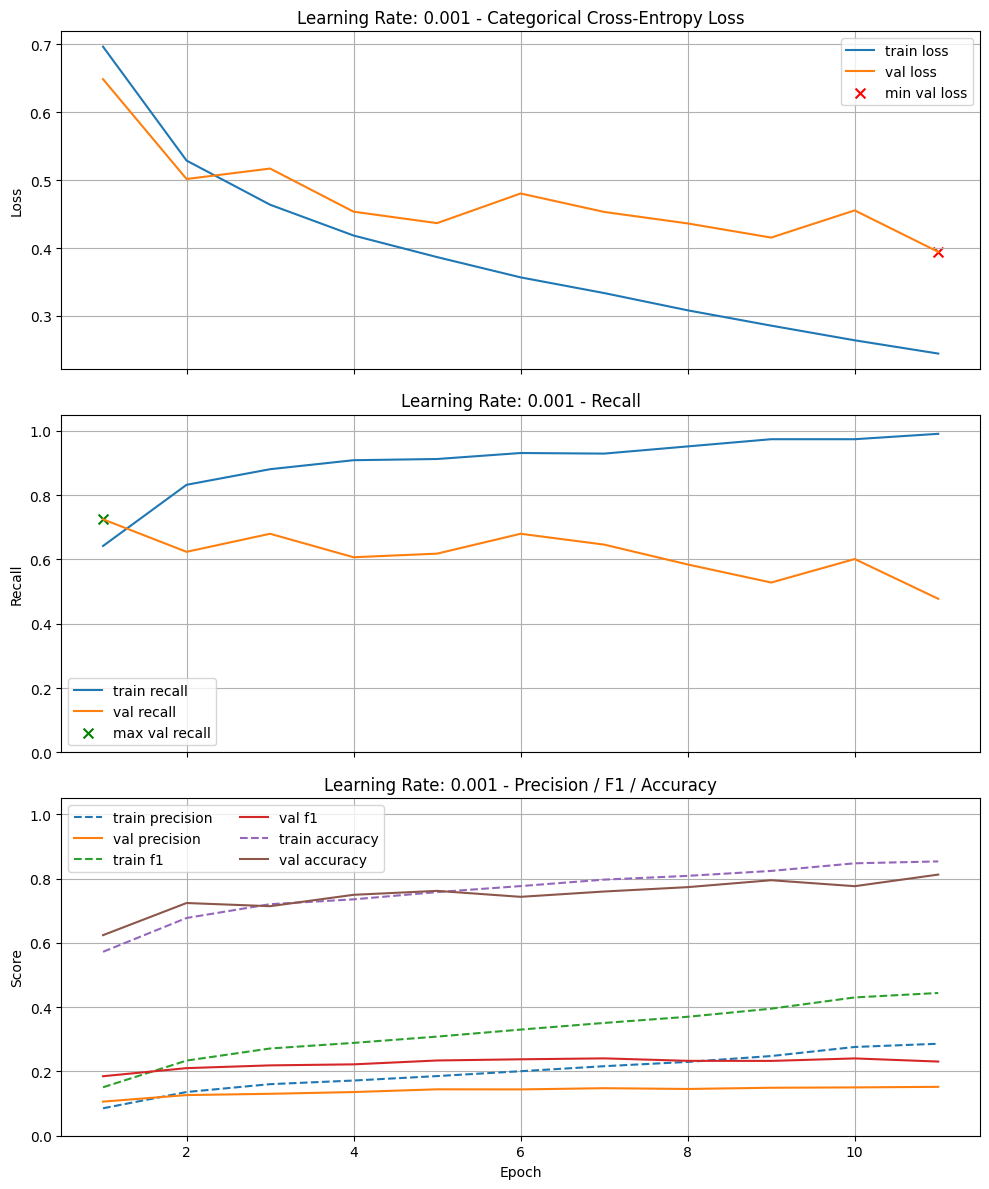


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step


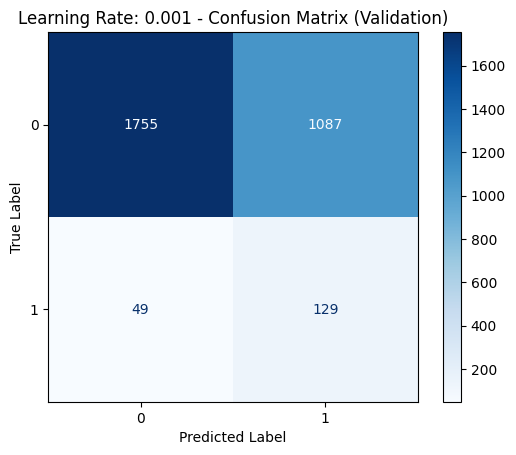

Final Training Metrics -> Loss: 0.2445, Precision: 0.2861, Recall: 0.9907, F1: 0.4440, Accuracy: 0.8532
Final Validation Metrics -> Loss: 0.3943, Precision: 0.1521, Recall: 0.4775, F1: 0.2307, Accuracy: 0.8123
Minimum Validation Loss: 0.3943 (Epoch 11)
Validation Metrics @ Min Loss -> Precision: 0.1521, Recall: 0.4775, F1: 0.2307, Accuracy: 0.8123
Best Validation Recall: 0.7247 (Epoch 1)
Best Validation Precision: 0.1521 (Epoch 11)
Best Validation F1: 0.2406 (Epoch 7)
Best Validation Accuracy: 0.8123 (Epoch 11)

Test Metrics -> Loss: 0.6584, Precision: 0.1035, Recall: 0.7416, F1: 0.1817, Accuracy: 0.6063

Validation-Test Gap -> Recall: 0.016854, Precision: 0.048528, F1: 0.058893, Accuracy: 0.205960

Execution Time: 00:00:03

Learning Rate: 0.0005


Test Metrics -> Loss: 0.6584, Precision: 0.1035, Recall: 0.7416, F1: 0.1817, Accuracy: 0.6063

Validation-Test Gap -> Recall: 0.016854, Precision: 0.048528, F1: 0.058893, Accuracy: 0.205960

Execution Time: 00:00:03

Learning Rate: 0.0005



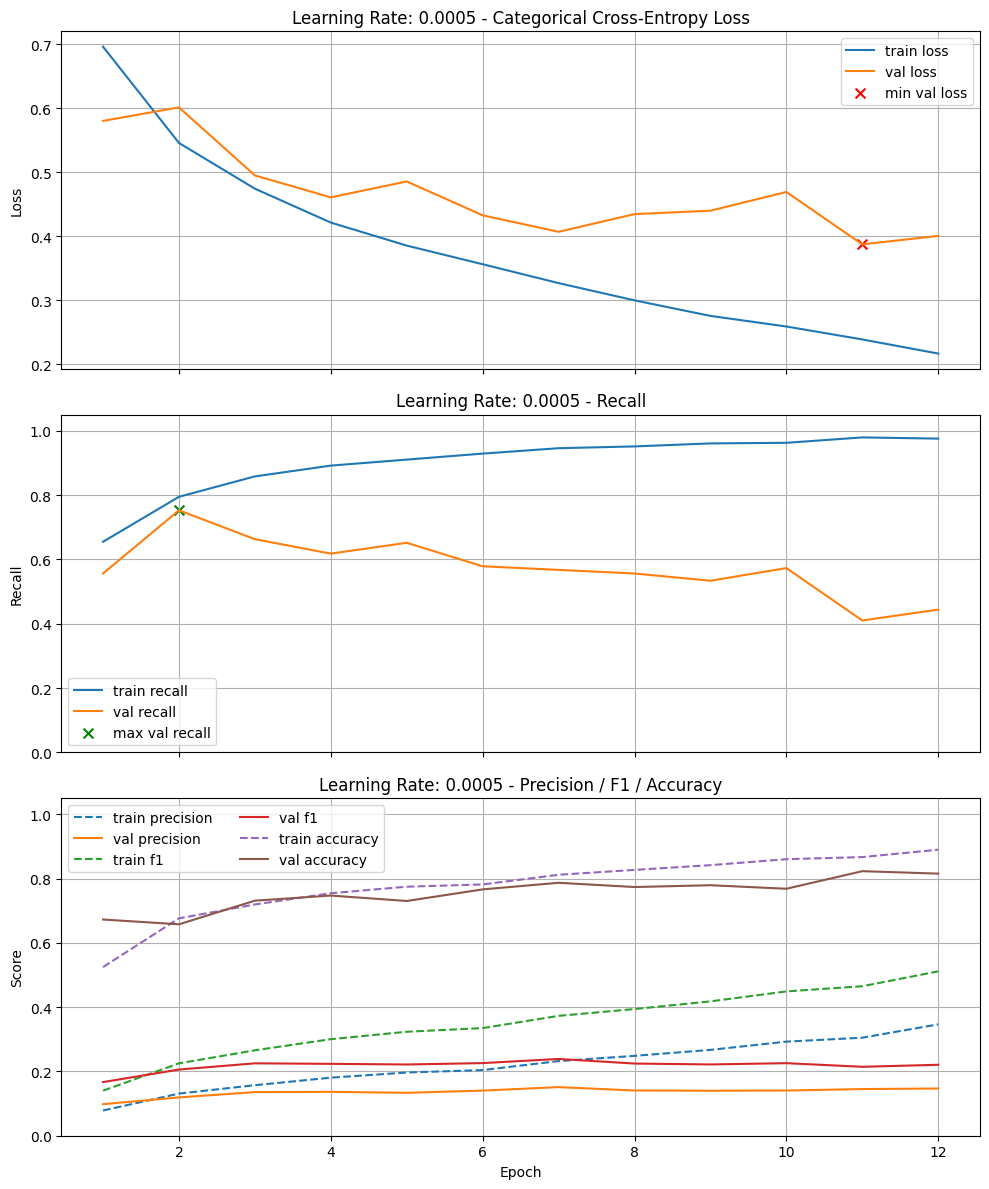


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


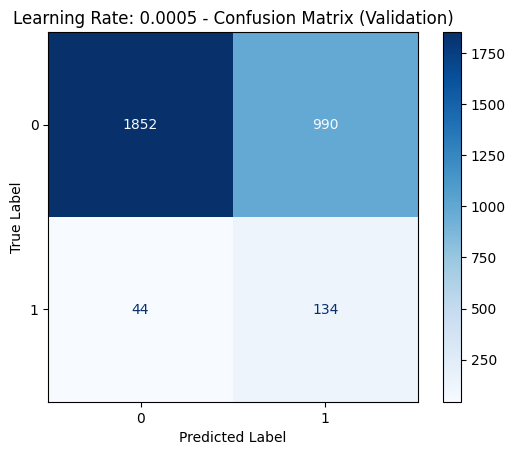

Final Training Metrics -> Loss: 0.2166, Precision: 0.3464, Recall: 0.9757, F1: 0.5112, Accuracy: 0.8896
Final Validation Metrics -> Loss: 0.4005, Precision: 0.1468, Recall: 0.4438, F1: 0.2207, Accuracy: 0.8152
Minimum Validation Loss: 0.3873 (Epoch 11)
Validation Metrics @ Min Loss -> Precision: 0.1451, Recall: 0.4101, F1: 0.2144, Accuracy: 0.8228
Best Validation Recall: 0.7528 (Epoch 2)
Best Validation Precision: 0.1512 (Epoch 7)
Best Validation F1: 0.2388 (Epoch 7)
Best Validation Accuracy: 0.8228 (Epoch 11)

Test Metrics -> Loss: 0.6051, Precision: 0.1217, Recall: 0.7809, F1: 0.2106, Accuracy: 0.6550

Validation-Test Gap -> Recall: 0.028090, Precision: 0.029481, F1: 0.028165, Accuracy: 0.167881

Execution Time: 00:00:03

Learning Rate: 0.0001


Test Metrics -> Loss: 0.6051, Precision: 0.1217, Recall: 0.7809, F1: 0.2106, Accuracy: 0.6550

Validation-Test Gap -> Recall: 0.028090, Precision: 0.029481, F1: 0.028165, Accuracy: 0.167881

Execution Time: 00:00:03

Learning Rate: 0.0001



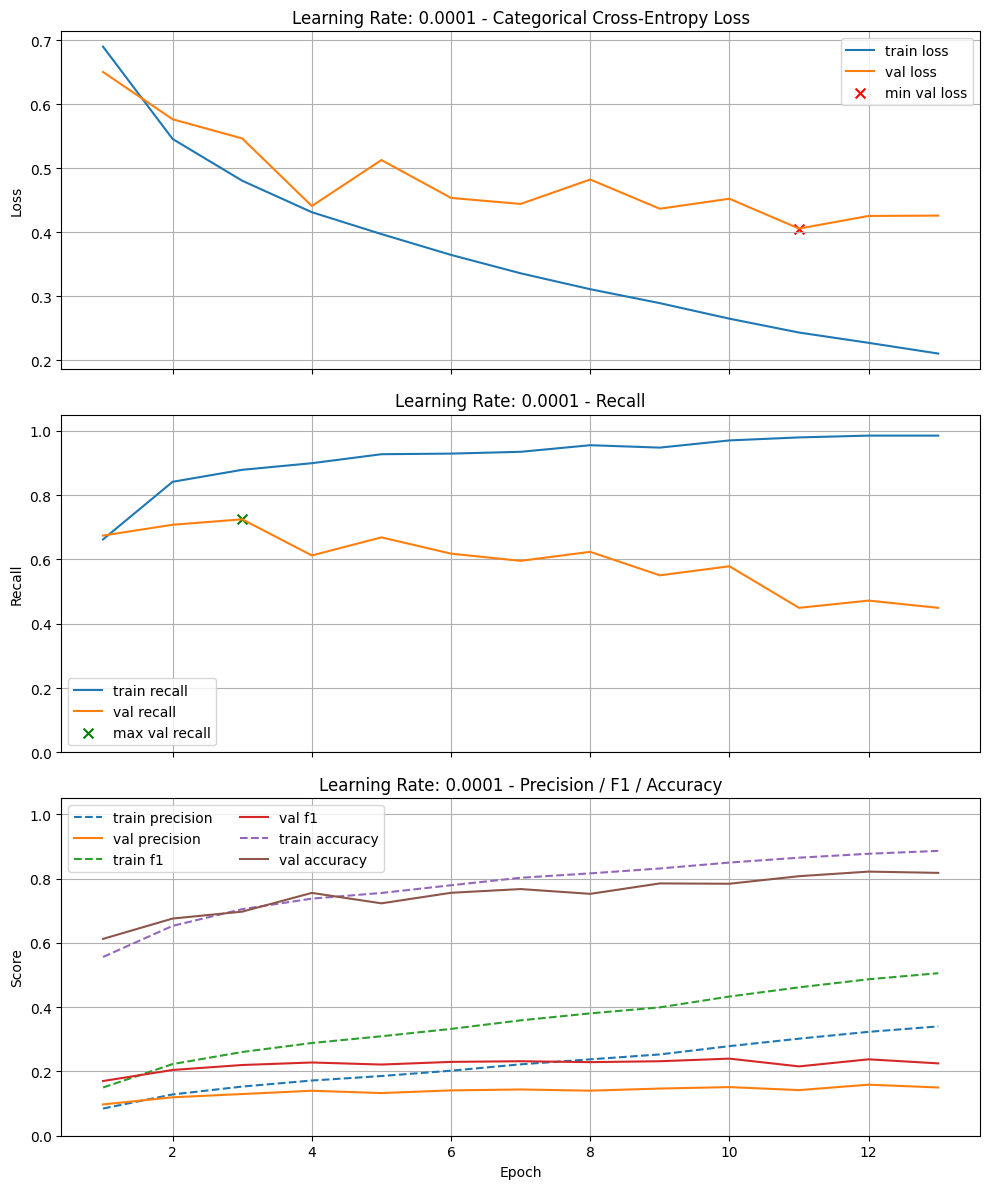


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step


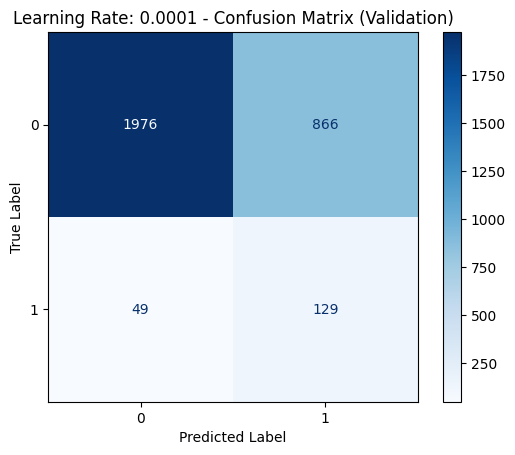

Final Training Metrics -> Loss: 0.2104, Precision: 0.3400, Recall: 0.9851, F1: 0.5055, Accuracy: 0.8860
Final Validation Metrics -> Loss: 0.4260, Precision: 0.1501, Recall: 0.4494, F1: 0.2250, Accuracy: 0.8175
Minimum Validation Loss: 0.4057 (Epoch 11)
Validation Metrics @ Min Loss -> Precision: 0.1418, Recall: 0.4494, F1: 0.2156, Accuracy: 0.8073
Best Validation Recall: 0.7247 (Epoch 3)
Best Validation Precision: 0.1588 (Epoch 12)
Best Validation F1: 0.2398 (Epoch 10)
Best Validation Accuracy: 0.8215 (Epoch 12)

Test Metrics -> Loss: 0.5416, Precision: 0.1341, Recall: 0.7472, F1: 0.2274, Accuracy: 0.7007

Validation-Test Gap -> Recall: 0.022472, Precision: 0.024718, F1: 0.012463, Accuracy: 0.120861

Execution Time: 00:00:04

Learning Rate: 5e-05


Test Metrics -> Loss: 0.5416, Precision: 0.1341, Recall: 0.7472, F1: 0.2274, Accuracy: 0.7007

Validation-Test Gap -> Recall: 0.022472, Precision: 0.024718, F1: 0.012463, Accuracy: 0.120861

Execution Time: 00:00:04

Learning Rate: 5e-05



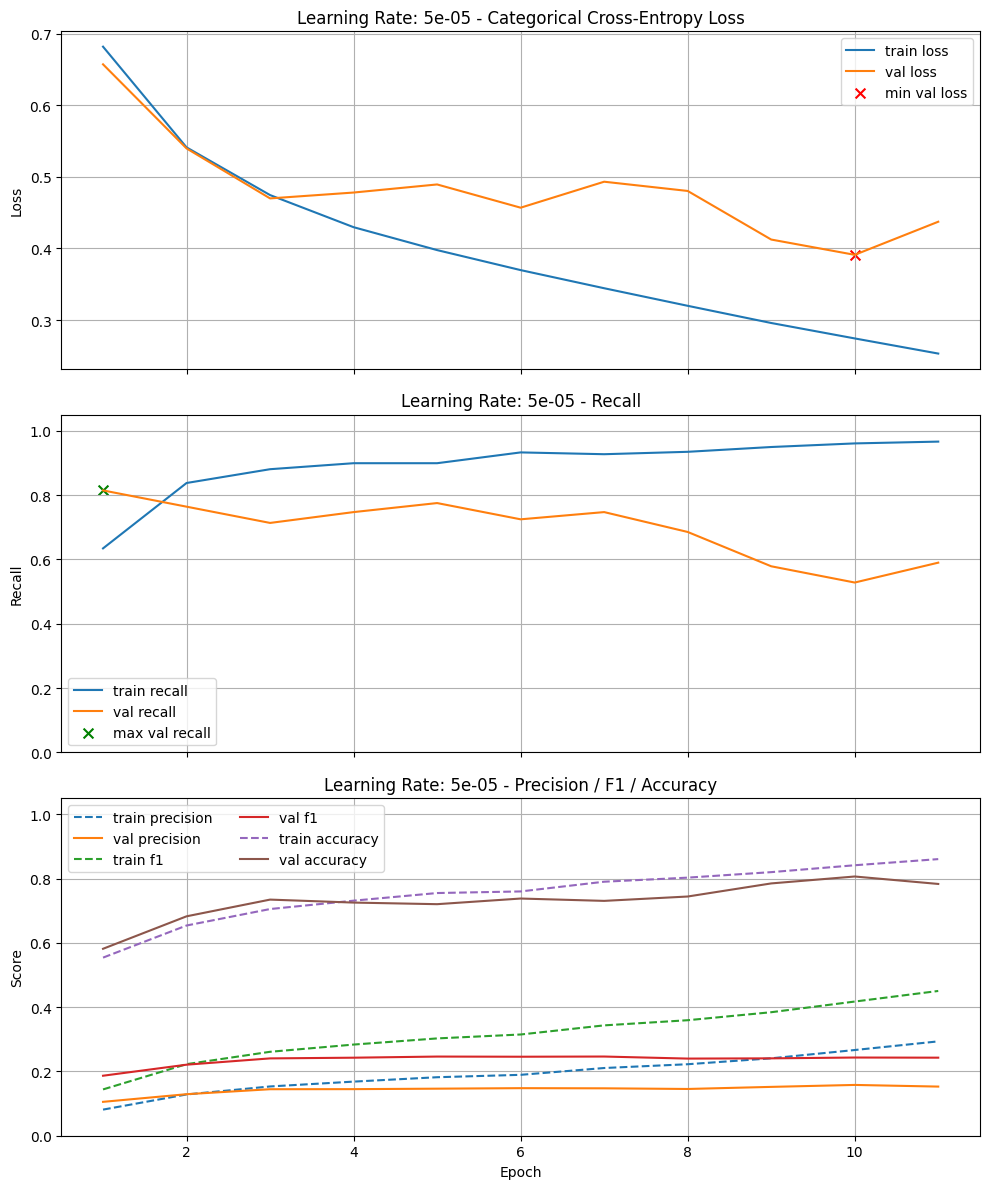


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step


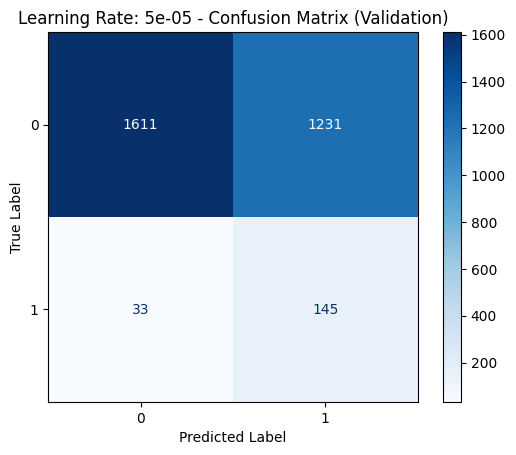

Final Training Metrics -> Loss: 0.2532, Precision: 0.2935, Recall: 0.9664, F1: 0.4502, Accuracy: 0.8604
Final Validation Metrics -> Loss: 0.4374, Precision: 0.1528, Recall: 0.5899, F1: 0.2428, Accuracy: 0.7831
Minimum Validation Loss: 0.3911 (Epoch 10)
Validation Metrics @ Min Loss -> Precision: 0.1580, Recall: 0.5281, F1: 0.2432, Accuracy: 0.8063
Best Validation Recall: 0.8146 (Epoch 1)
Best Validation Precision: 0.1580 (Epoch 10)
Best Validation F1: 0.2463 (Epoch 7)
Best Validation Accuracy: 0.8063 (Epoch 10)

Test Metrics -> Loss: 0.6604, Precision: 0.0983, Recall: 0.7640, F1: 0.1741, Accuracy: 0.5728

Validation-Test Gap -> Recall: 0.050562, Precision: 0.059717, F1: 0.072161, Accuracy: 0.233444

Execution Time: 00:00:03

Learning Rate: 1e-05


Test Metrics -> Loss: 0.6604, Precision: 0.0983, Recall: 0.7640, F1: 0.1741, Accuracy: 0.5728

Validation-Test Gap -> Recall: 0.050562, Precision: 0.059717, F1: 0.072161, Accuracy: 0.233444

Execution Time: 00:00:03

Learning Rate: 1e-05



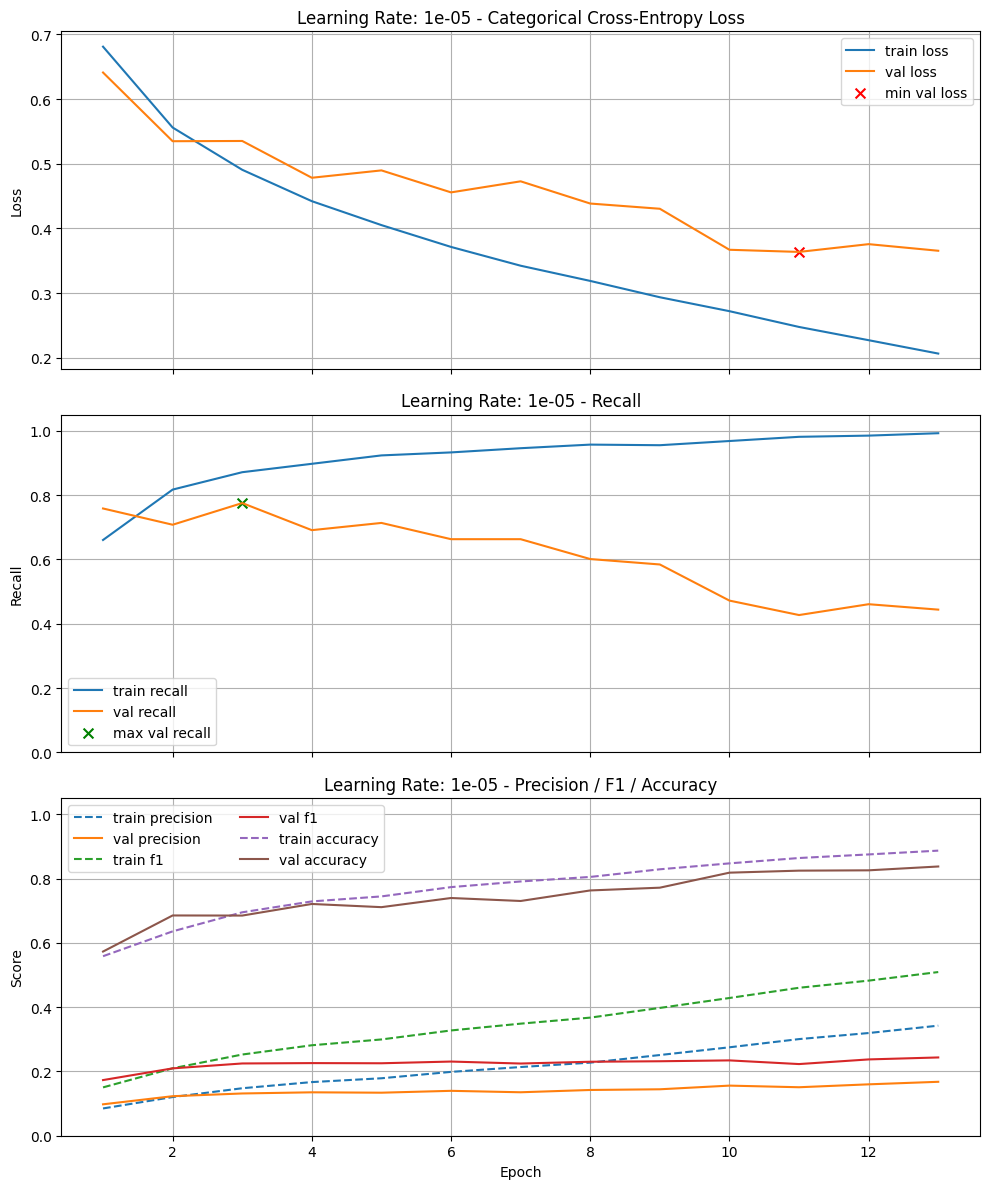


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step


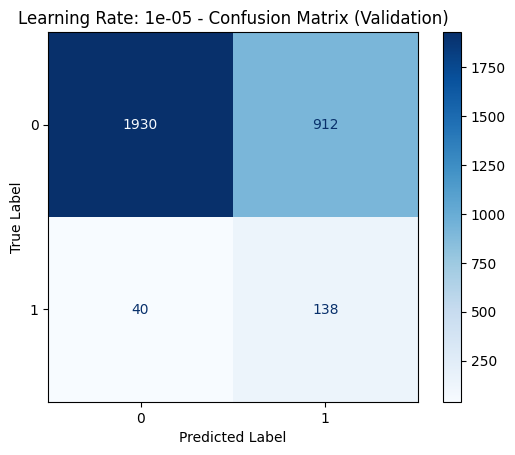

Final Training Metrics -> Loss: 0.2067, Precision: 0.3423, Recall: 0.9925, F1: 0.5091, Accuracy: 0.8868
Final Validation Metrics -> Loss: 0.3655, Precision: 0.1677, Recall: 0.4438, F1: 0.2435, Accuracy: 0.8374
Minimum Validation Loss: 0.3637 (Epoch 11)
Validation Metrics @ Min Loss -> Precision: 0.1508, Recall: 0.4270, F1: 0.2229, Accuracy: 0.8245
Best Validation Recall: 0.7753 (Epoch 3)
Best Validation Precision: 0.1677 (Epoch 13)
Best Validation F1: 0.2435 (Epoch 13)
Best Validation Accuracy: 0.8374 (Epoch 13)

Test Metrics -> Loss: 0.5346, Precision: 0.1277, Recall: 0.7584, F1: 0.2186, Accuracy: 0.6805

Validation-Test Gap -> Recall: 0.016854, Precision: 0.040008, F1: 0.024828, Accuracy: 0.156954

Execution Time: 00:00:03

Test Metrics -> Loss: 0.5346, Precision: 0.1277, Recall: 0.7584, F1: 0.2186, Accuracy: 0.6805

Validation-Test Gap -> Recall: 0.016854, Precision: 0.040008, F1: 0.024828, Accuracy: 0.156954

Execution Time: 00:00:03


In [14]:
# Your code here. Add as many cells as you need.
af = 'relu'
learning_rate = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

results_2 = pd.DataFrame(columns=[
    'Title',
    'Best Val Recall',
    'Best Val Precision',
    'Best Val F1',
    'Best Val Accuracy',
    'Min Val Loss',
    'Val Recall @ Min Loss',
    'Val Precision @ Min Loss',
    'Val F1 @ Min Loss',
    'Test Recall',
    'Test Precision',
    'Test F1',
    'Test Accuracy'
], index=[0,1,2,3,4])

for i, lr in enumerate(learning_rate):
    model = build_model(X_train.shape[1], [ (64, af, 0.0, 0.0), (32, af, 0.0, 0.0)], n_classes)
    history, metrics = train_and_test(model, title=f"Learning Rate: {lr}", verbose=0, return_history = True)
    results_2.loc[i] = [
        f"Learning Rate: {lr}",
        metrics['best_val_recall'],
        metrics['best_val_precision'],
        metrics['best_val_f1'],
        metrics['best_val_accuracy'],
        metrics['min_val_loss'],
        metrics['val_recall_at_min_loss'],
        metrics['val_precision_at_min_loss'],
        metrics['val_f1_at_min_loss'],
        metrics['test_recall'],
        metrics['test_precision'],
        metrics['test_f1'],
        metrics['test_accuracy']
    ]

In [15]:
results_2

,Title,Best Val Recall,Best Val Precision,Best Val F1,Best Val Accuracy,Min Val Loss,Val Recall @ Min Loss,Val Precision @ Min Loss,Val F1 @ Min Loss,Test Recall,Test Precision,Test F1,Test Accuracy
0,Learning Rate: 0.001,0.724719,0.152057,0.240586,0.812252,0.394327,0.477528,0.152057,0.230665,0.741573,0.103529,0.181693,0.606291
1,Learning Rate: 0.0005,0.752809,0.151198,0.238771,0.822848,0.387274,0.410112,0.145129,0.214391,0.780899,0.121716,0.210606,0.654967
2,Learning Rate: 0.0001,0.724719,0.15879,0.239814,0.821523,0.405692,0.449438,0.141844,0.215633,0.747191,0.134073,0.22735,0.700662
3,Learning Rate: 5e-05,0.814607,0.157983,0.246296,0.806291,0.391121,0.52809,0.157983,0.243208,0.764045,0.098266,0.174136,0.572848
4,Learning Rate: 1e-05,0.775281,0.167728,0.243451,0.837417,0.36372,0.426966,0.150794,0.222874,0.758427,0.12772,0.218623,0.680464


### Dropout Testing


Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.3



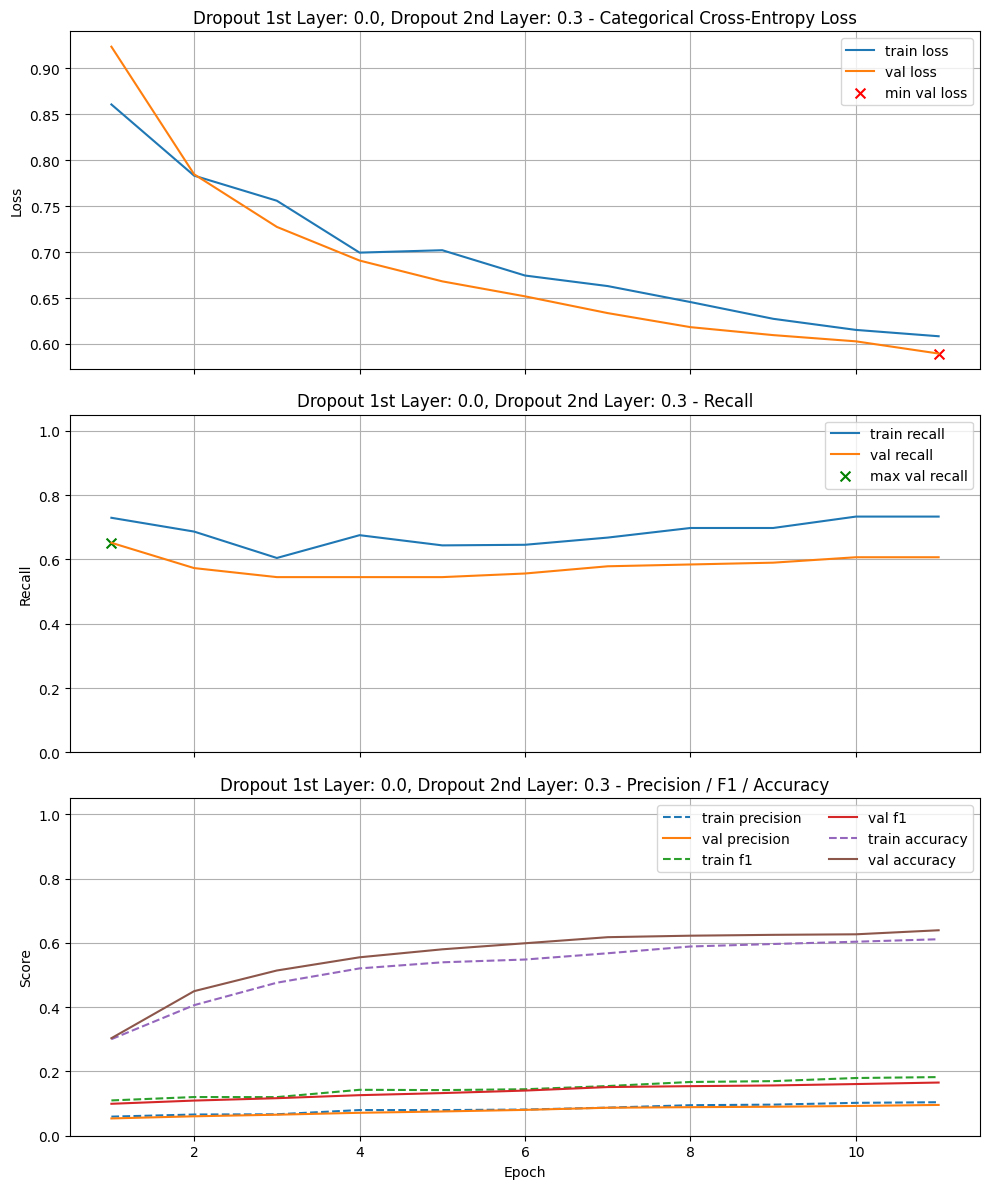


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step


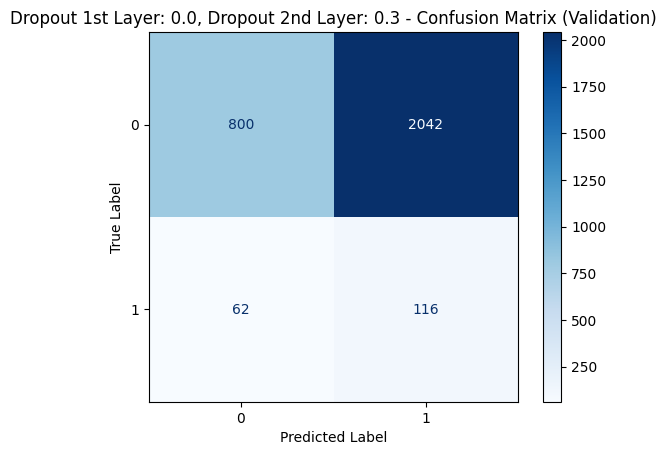

Final Training Metrics -> Loss: 0.6084, Precision: 0.1042, Recall: 0.7332, F1: 0.1824, Accuracy: 0.6111
Final Validation Metrics -> Loss: 0.5895, Precision: 0.0957, Recall: 0.6067, F1: 0.1654, Accuracy: 0.6391
Minimum Validation Loss: 0.5895 (Epoch 11)
Validation Metrics @ Min Loss -> Precision: 0.0957, Recall: 0.6067, F1: 0.1654, Accuracy: 0.6391
Best Validation Recall: 0.6517 (Epoch 1)
Best Validation Precision: 0.0957 (Epoch 11)
Best Validation F1: 0.1654 (Epoch 11)
Best Validation Accuracy: 0.6391 (Epoch 11)

Test Metrics -> Loss: 0.9266, Precision: 0.0576, Recall: 0.6854, F1: 0.1062, Accuracy: 0.3202

Validation-Test Gap -> Recall: 0.033708, Precision: 0.038170, F1: 0.059165, Accuracy: 0.318874

Execution Time: 00:00:03

Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.4


Test Metrics -> Loss: 0.9266, Precision: 0.0576, Recall: 0.6854, F1: 0.1062, Accuracy: 0.3202

Validation-Test Gap -> Recall: 0.033708, Precision: 0.038170, F1: 0.059165, Accuracy: 0.318874

Execution Time: 00:00:03

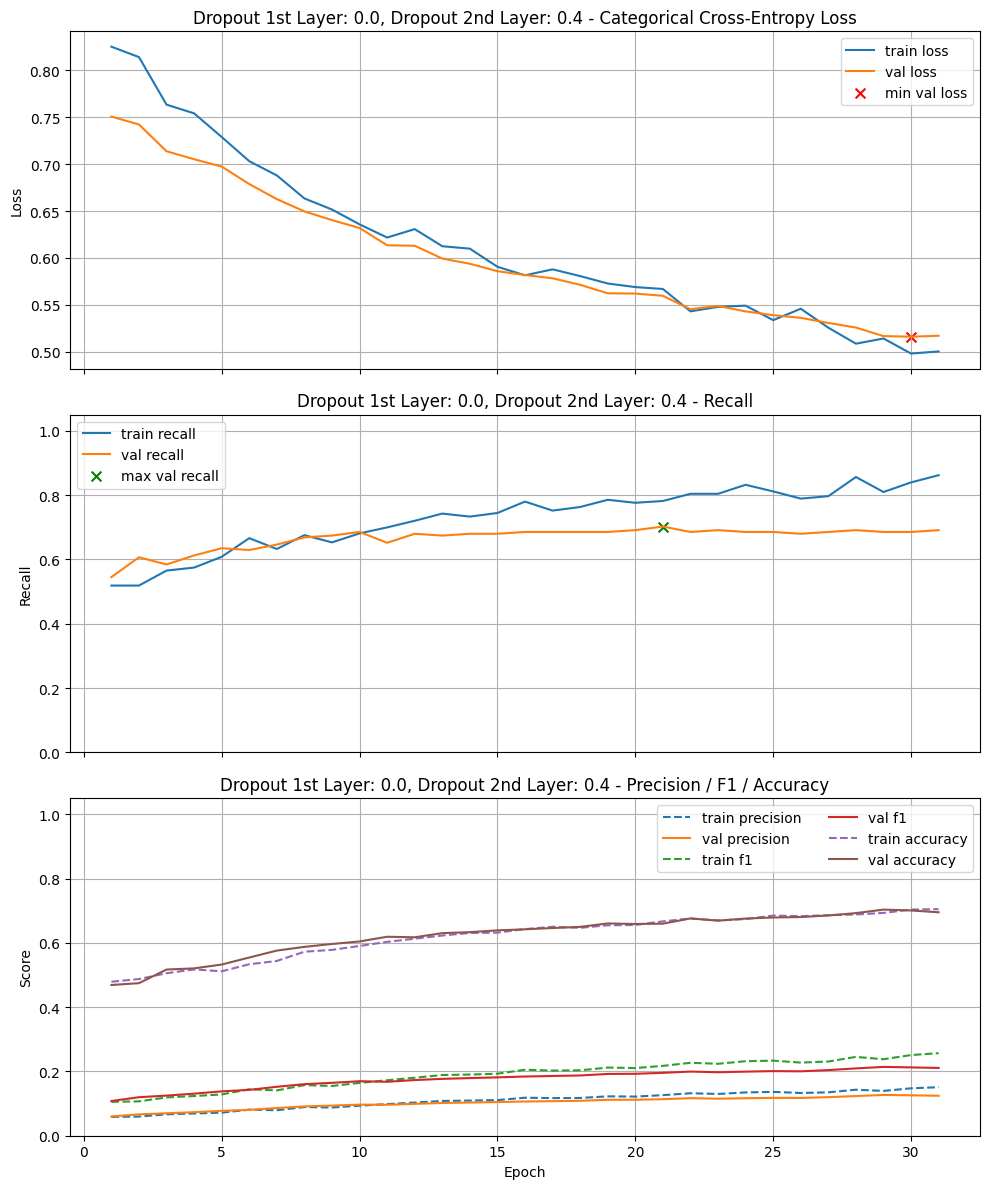


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step


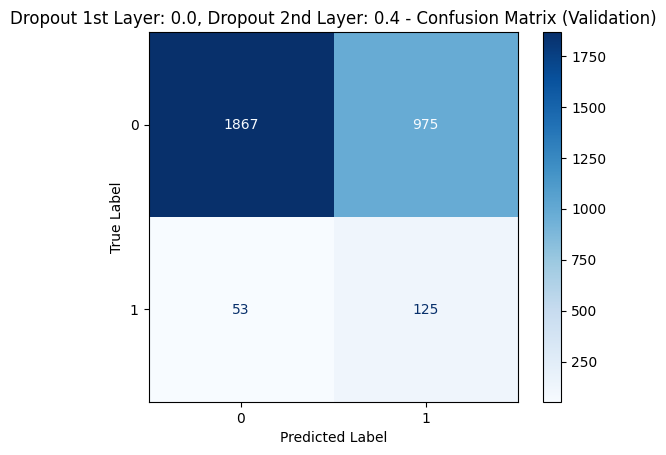

Final Training Metrics -> Loss: 0.5004, Precision: 0.1509, Recall: 0.8619, F1: 0.2568, Accuracy: 0.7049
Final Validation Metrics -> Loss: 0.5171, Precision: 0.1244, Recall: 0.6910, F1: 0.2108, Accuracy: 0.6950
Minimum Validation Loss: 0.5161 (Epoch 30)
Validation Metrics @ Min Loss -> Precision: 0.1258, Recall: 0.6854, F1: 0.2125, Accuracy: 0.7007
Best Validation Recall: 0.7022 (Epoch 21)
Best Validation Precision: 0.1268 (Epoch 29)
Best Validation F1: 0.2140 (Epoch 29)
Best Validation Accuracy: 0.7033 (Epoch 29)

Test Metrics -> Loss: 0.5654, Precision: 0.1157, Recall: 0.7079, F1: 0.1989, Accuracy: 0.6639

Validation-Test Gap -> Recall: 0.005618, Precision: 0.011117, F1: 0.015140, Accuracy: 0.039404

Execution Time: 00:00:06

Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.5


Test Metrics -> Loss: 0.5654, Precision: 0.1157, Recall: 0.7079, F1: 0.1989, Accuracy: 0.6639

Validation-Test Gap -> Recall: 0.005618, Precision: 0.011117, F1: 0.015140, Accuracy: 0.039404

Execution Time: 00:00:0

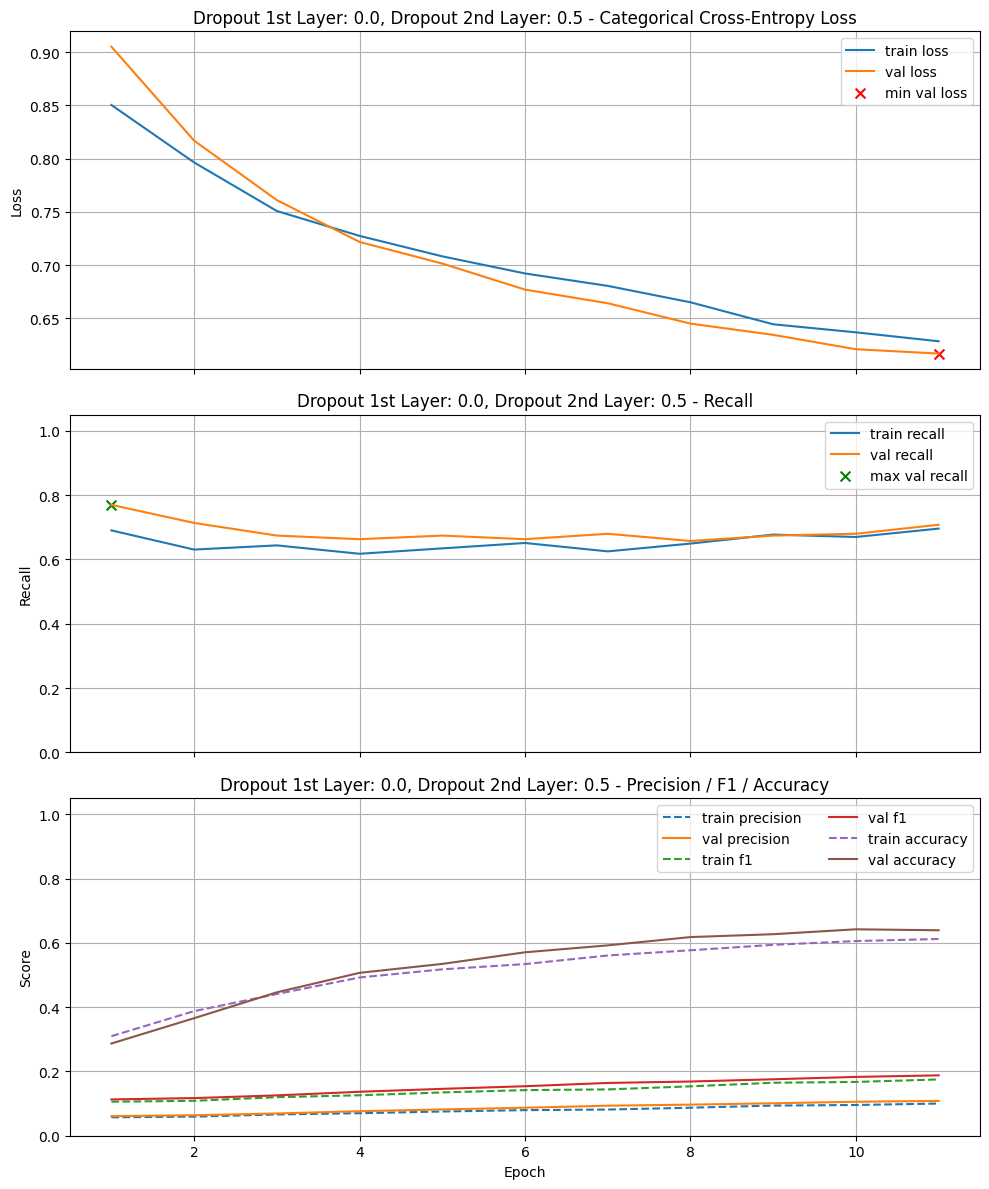


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step


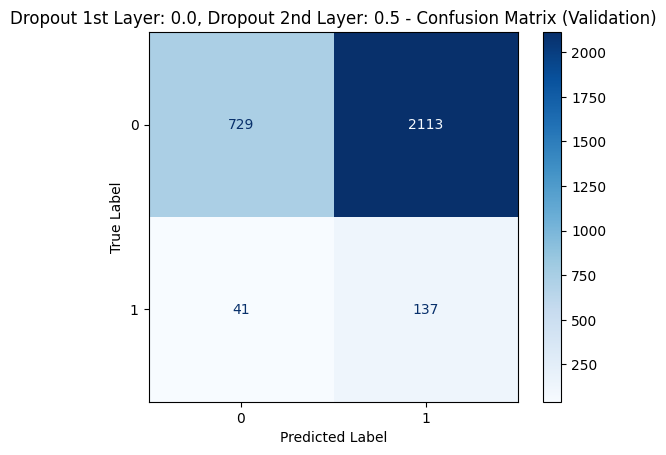

Final Training Metrics -> Loss: 0.6284, Precision: 0.1001, Recall: 0.6959, F1: 0.1750, Accuracy: 0.6119
Final Validation Metrics -> Loss: 0.6168, Precision: 0.1082, Recall: 0.7079, F1: 0.1878, Accuracy: 0.6391
Minimum Validation Loss: 0.6168 (Epoch 11)
Validation Metrics @ Min Loss -> Precision: 0.1082, Recall: 0.7079, F1: 0.1878, Accuracy: 0.6391
Best Validation Recall: 0.7697 (Epoch 1)
Best Validation Precision: 0.1082 (Epoch 11)
Best Validation F1: 0.1878 (Epoch 11)
Best Validation Accuracy: 0.6421 (Epoch 10)

Test Metrics -> Loss: 0.8999, Precision: 0.0590, Recall: 0.7416, F1: 0.1092, Accuracy: 0.2871

Validation-Test Gap -> Recall: 0.028090, Precision: 0.049293, F1: 0.078553, Accuracy: 0.354967

Execution Time: 00:00:03

Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.3


Test Metrics -> Loss: 0.8999, Precision: 0.0590, Recall: 0.7416, F1: 0.1092, Accuracy: 0.2871

Validation-Test Gap -> Recall: 0.028090, Precision: 0.049293, F1: 0.078553, Accuracy: 0.354967

Execution Time: 00:00:03

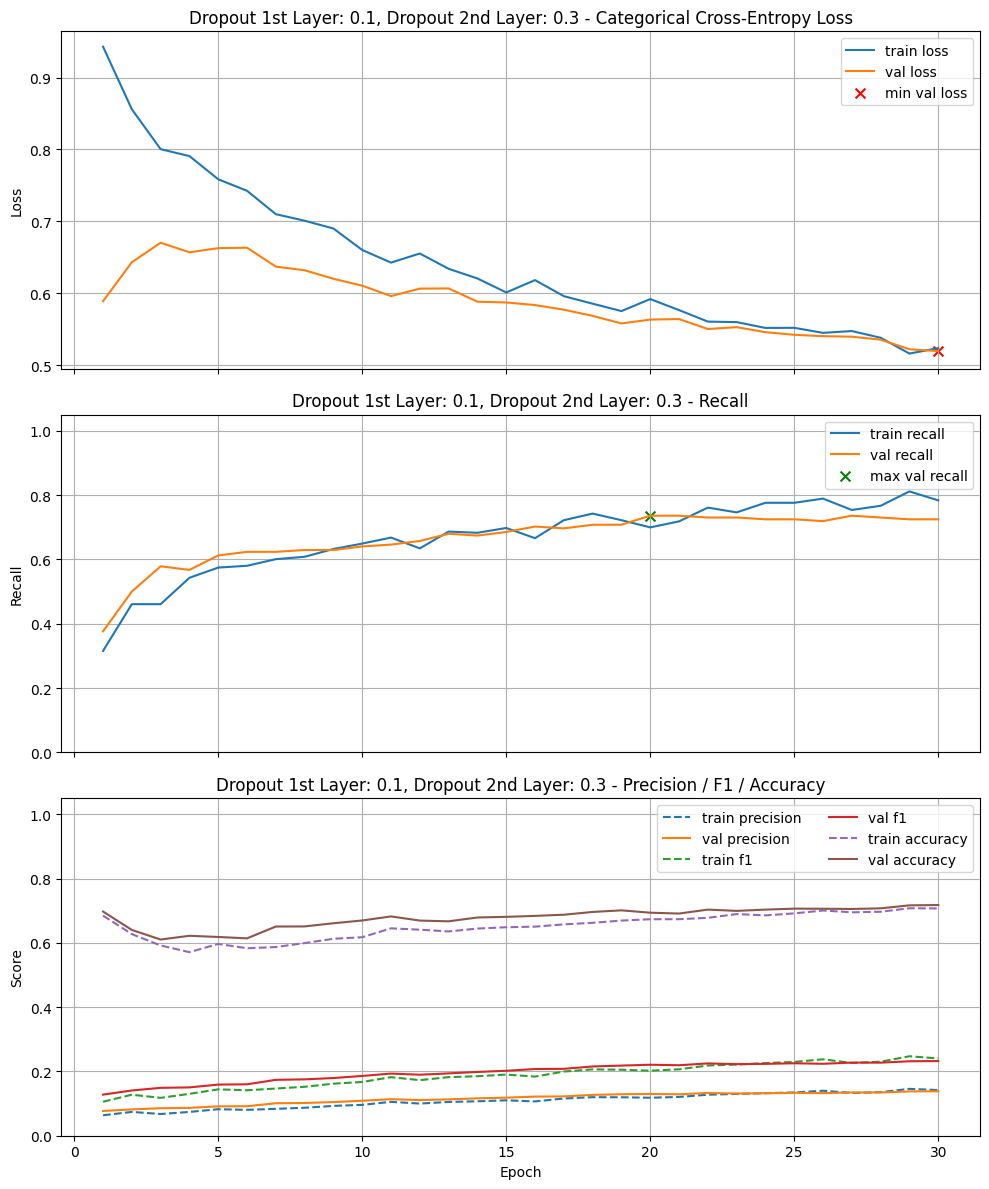


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


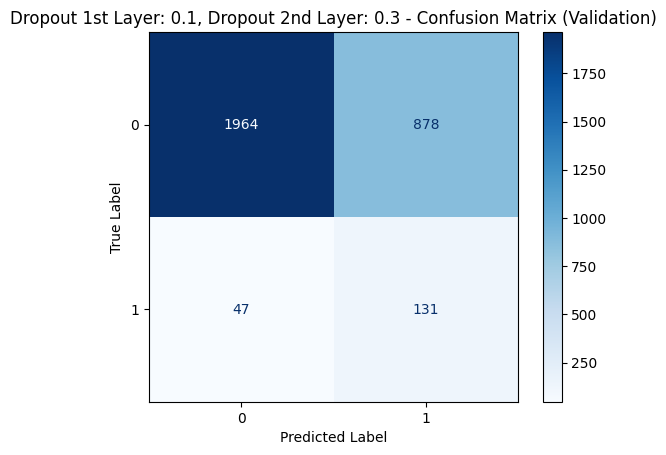

Final Training Metrics -> Loss: 0.5236, Precision: 0.1419, Recall: 0.7836, F1: 0.2403, Accuracy: 0.7070
Final Validation Metrics -> Loss: 0.5194, Precision: 0.1383, Recall: 0.7247, F1: 0.2322, Accuracy: 0.7175
Minimum Validation Loss: 0.5194 (Epoch 30)
Validation Metrics @ Min Loss -> Precision: 0.1383, Recall: 0.7247, F1: 0.2322, Accuracy: 0.7175
Best Validation Recall: 0.7360 (Epoch 20)
Best Validation Precision: 0.1383 (Epoch 30)
Best Validation F1: 0.2322 (Epoch 30)
Best Validation Accuracy: 0.7175 (Epoch 30)

Test Metrics -> Loss: 0.5808, Precision: 0.1106, Recall: 0.6573, F1: 0.1893, Accuracy: 0.6682

Validation-Test Gap -> Recall: 0.078652, Precision: 0.027678, F1: 0.042903, Accuracy: 0.049338

Execution Time: 00:00:06

Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.4


Test Metrics -> Loss: 0.5808, Precision: 0.1106, Recall: 0.6573, F1: 0.1893, Accuracy: 0.6682

Validation-Test Gap -> Recall: 0.078652, Precision: 0.027678, F1: 0.042903, Accuracy: 0.049338

Execution Time: 00:00:0

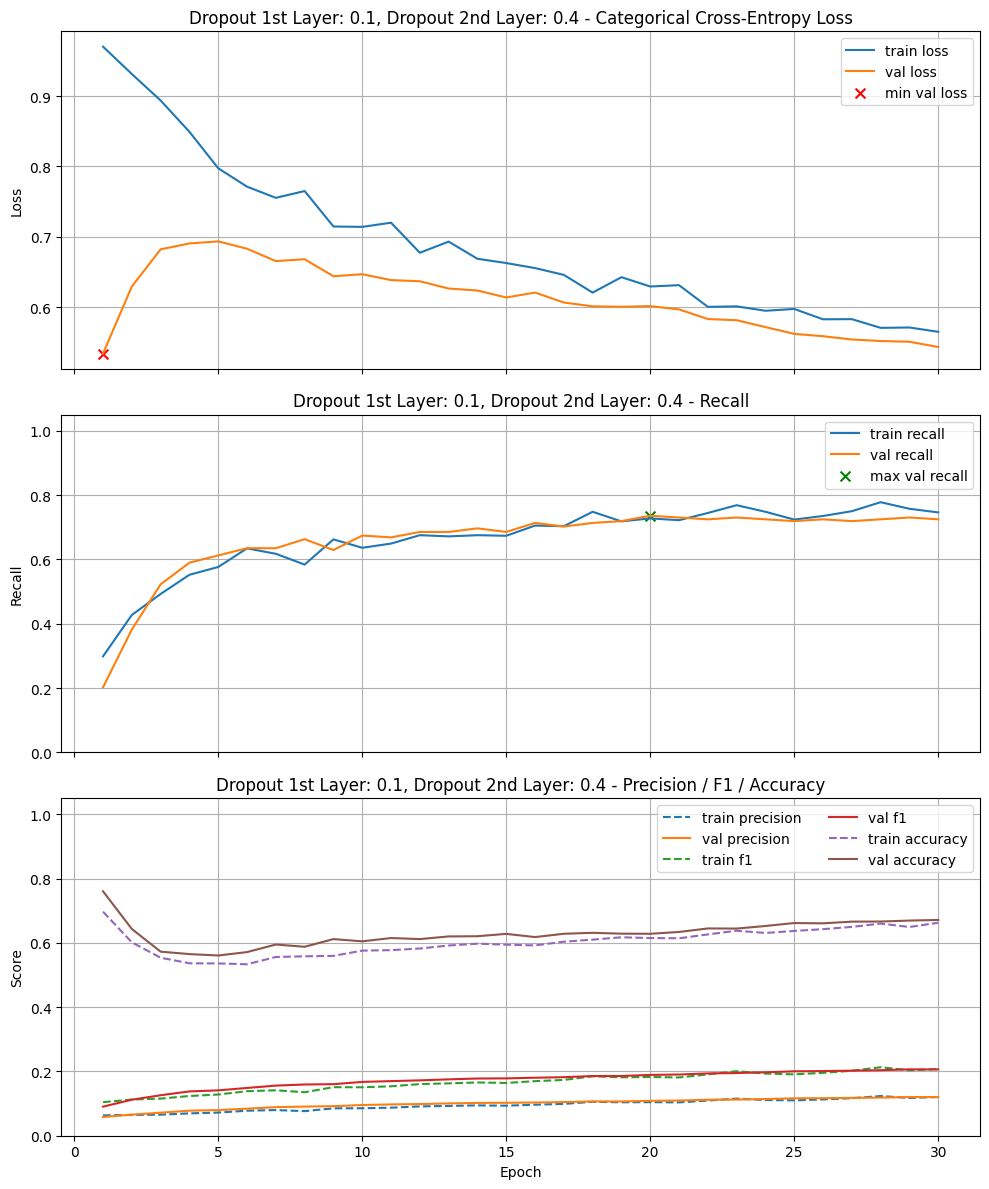


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


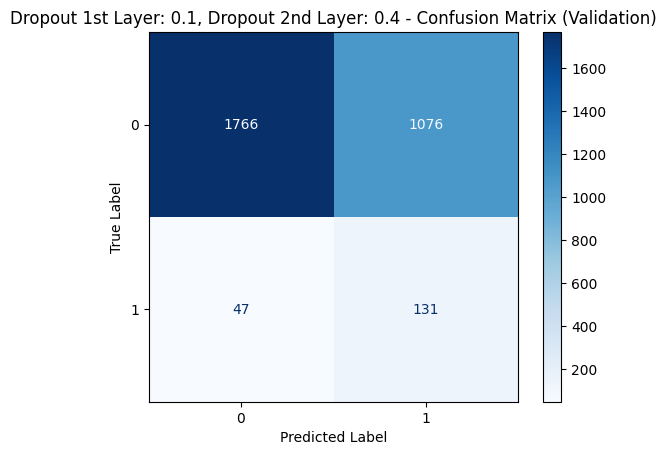

Final Training Metrics -> Loss: 0.5648, Precision: 0.1204, Recall: 0.7463, F1: 0.2074, Accuracy: 0.6625
Final Validation Metrics -> Loss: 0.5433, Precision: 0.1202, Recall: 0.7247, F1: 0.2062, Accuracy: 0.6712
Minimum Validation Loss: 0.5339 (Epoch 1)
Validation Metrics @ Min Loss -> Precision: 0.0583, Recall: 0.2022, F1: 0.0905, Accuracy: 0.7603
Best Validation Recall: 0.7360 (Epoch 20)
Best Validation Precision: 0.1203 (Epoch 29)
Best Validation F1: 0.2065 (Epoch 29)
Best Validation Accuracy: 0.7603 (Epoch 1)

Test Metrics -> Loss: 0.6075, Precision: 0.1115, Recall: 0.7584, F1: 0.1944, Accuracy: 0.6295

Validation-Test Gap -> Recall: 0.022472, Precision: 0.008781, F1: 0.012129, Accuracy: 0.130795

Execution Time: 00:00:07

Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.5


Test Metrics -> Loss: 0.6075, Precision: 0.1115, Recall: 0.7584, F1: 0.1944, Accuracy: 0.6295

Validation-Test Gap -> Recall: 0.022472, Precision: 0.008781, F1: 0.012129, Accuracy: 0.130795

Execution Time: 00:00:07


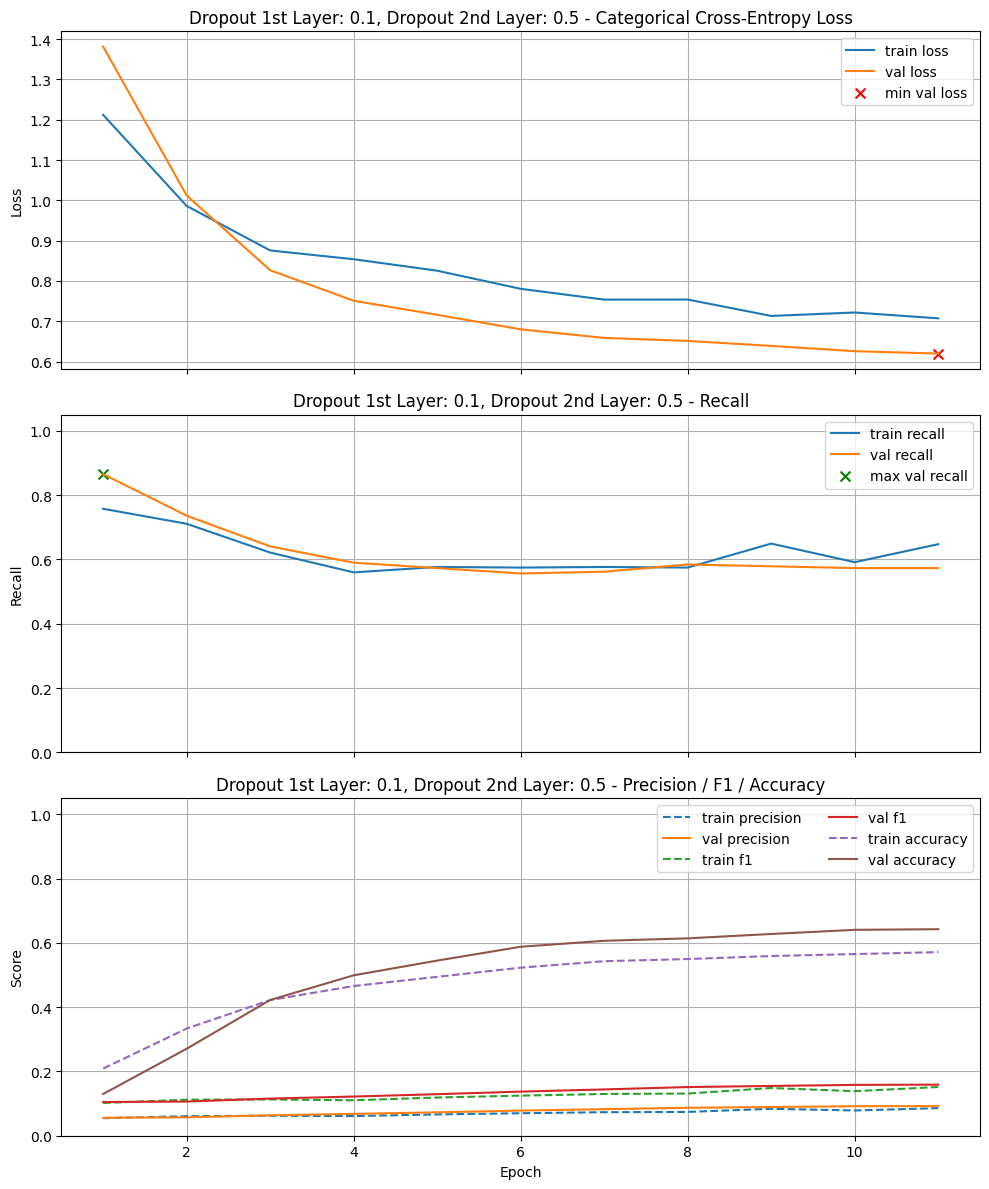


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step


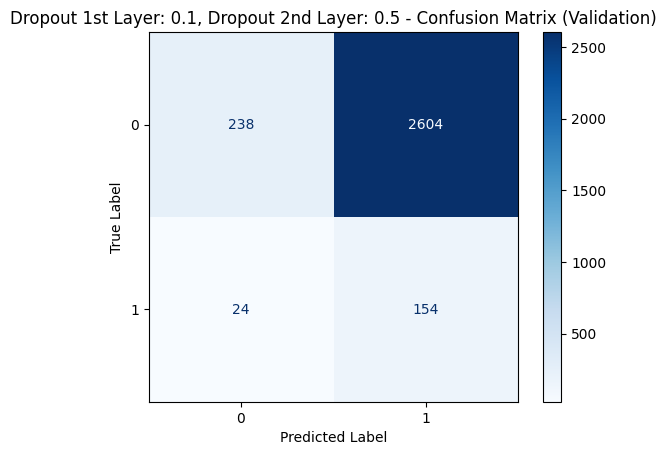

Final Training Metrics -> Loss: 0.7072, Precision: 0.0858, Recall: 0.6474, F1: 0.1515, Accuracy: 0.5711
Final Validation Metrics -> Loss: 0.6198, Precision: 0.0922, Recall: 0.5730, F1: 0.1589, Accuracy: 0.6424
Minimum Validation Loss: 0.6198 (Epoch 11)
Validation Metrics @ Min Loss -> Precision: 0.0922, Recall: 0.5730, F1: 0.1589, Accuracy: 0.6424
Best Validation Recall: 0.8652 (Epoch 1)
Best Validation Precision: 0.0922 (Epoch 11)
Best Validation F1: 0.1589 (Epoch 11)
Best Validation Accuracy: 0.6424 (Epoch 11)

Test Metrics -> Loss: 1.4076, Precision: 0.0594, Recall: 0.9382, F1: 0.1117, Accuracy: 0.1205

Validation-Test Gap -> Recall: 0.073034, Precision: 0.032836, F1: 0.047173, Accuracy: 0.521854

Execution Time: 00:00:03

Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.3


Test Metrics -> Loss: 1.4076, Precision: 0.0594, Recall: 0.9382, F1: 0.1117, Accuracy: 0.1205

Validation-Test Gap -> Recall: 0.073034, Precision: 0.032836, F1: 0.047173, Accuracy: 0.521854

Execution Time: 00:00:03

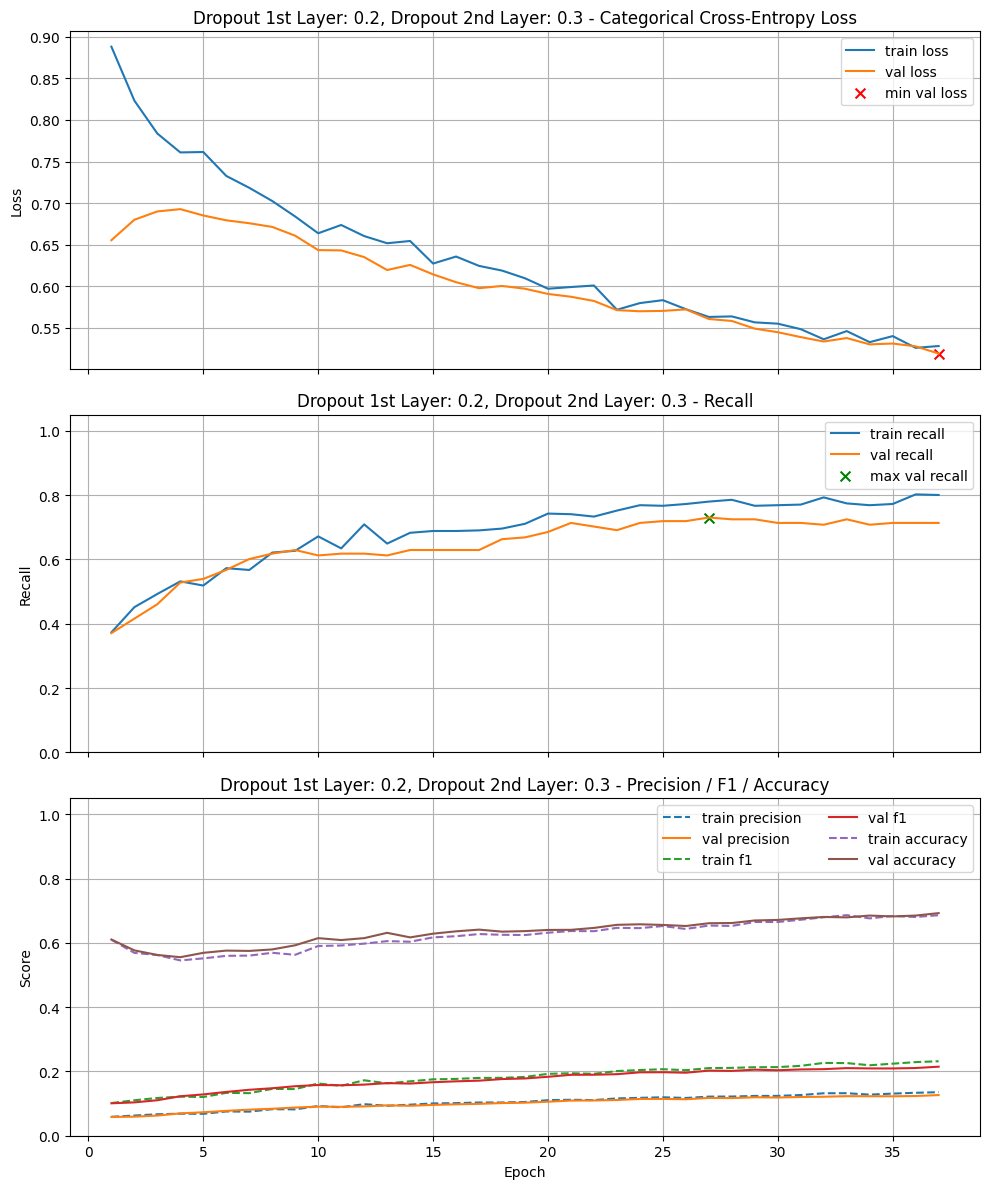


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


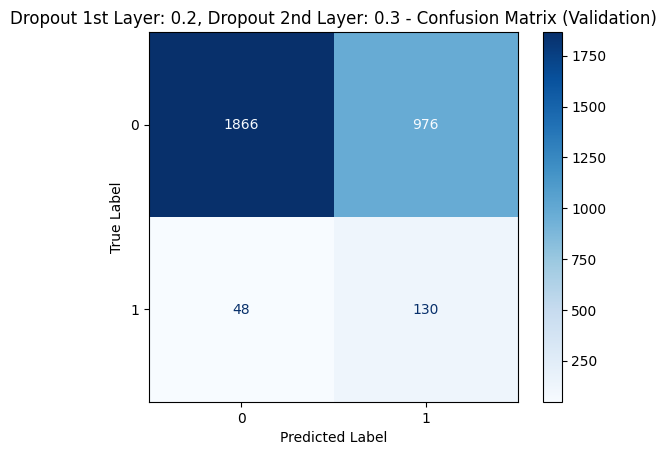

Final Training Metrics -> Loss: 0.5281, Precision: 0.1354, Recall: 0.8004, F1: 0.2316, Accuracy: 0.6859
Final Validation Metrics -> Loss: 0.5190, Precision: 0.1264, Recall: 0.7135, F1: 0.2147, Accuracy: 0.6924
Minimum Validation Loss: 0.5190 (Epoch 37)
Validation Metrics @ Min Loss -> Precision: 0.1264, Recall: 0.7135, F1: 0.2147, Accuracy: 0.6924
Best Validation Recall: 0.7303 (Epoch 27)
Best Validation Precision: 0.1264 (Epoch 37)
Best Validation F1: 0.2147 (Epoch 37)
Best Validation Accuracy: 0.6924 (Epoch 37)

Test Metrics -> Loss: 0.5631, Precision: 0.1155, Recall: 0.7360, F1: 0.1997, Accuracy: 0.6523

Validation-Test Gap -> Recall: 0.005618, Precision: 0.010848, F1: 0.015013, Accuracy: 0.040066

Execution Time: 00:00:08

Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.4


Test Metrics -> Loss: 0.5631, Precision: 0.1155, Recall: 0.7360, F1: 0.1997, Accuracy: 0.6523

Validation-Test Gap -> Recall: 0.005618, Precision: 0.010848, F1: 0.015013, Accuracy: 0.040066

Execution Time: 00:00:0

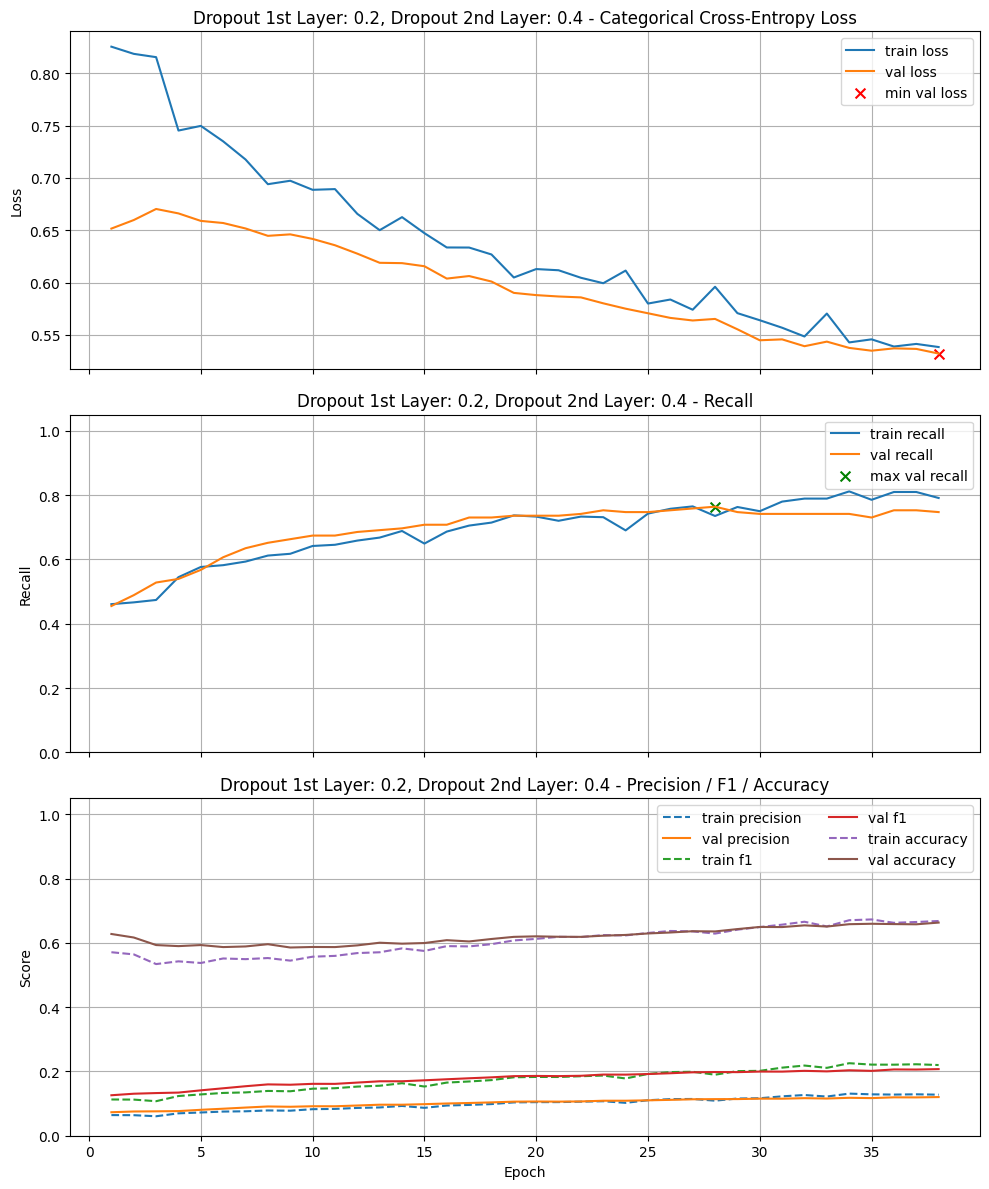


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step


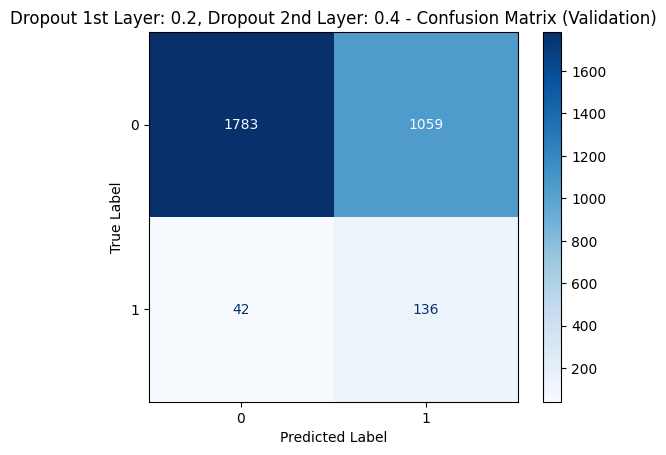

Final Training Metrics -> Loss: 0.5383, Precision: 0.1277, Recall: 0.7910, F1: 0.2199, Accuracy: 0.6679
Final Validation Metrics -> Loss: 0.5321, Precision: 0.1203, Recall: 0.7472, F1: 0.2072, Accuracy: 0.6629
Minimum Validation Loss: 0.5321 (Epoch 38)
Validation Metrics @ Min Loss -> Precision: 0.1203, Recall: 0.7472, F1: 0.2072, Accuracy: 0.6629
Best Validation Recall: 0.7640 (Epoch 28)
Best Validation Precision: 0.1203 (Epoch 38)
Best Validation F1: 0.2072 (Epoch 38)
Best Validation Accuracy: 0.6629 (Epoch 38)

Test Metrics -> Loss: 0.5676, Precision: 0.1204, Recall: 0.8202, F1: 0.2099, Accuracy: 0.6361

Validation-Test Gap -> Recall: 0.056180, Precision: 0.000110, F1: 0.002756, Accuracy: 0.026821

Execution Time: 00:00:08

Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.5



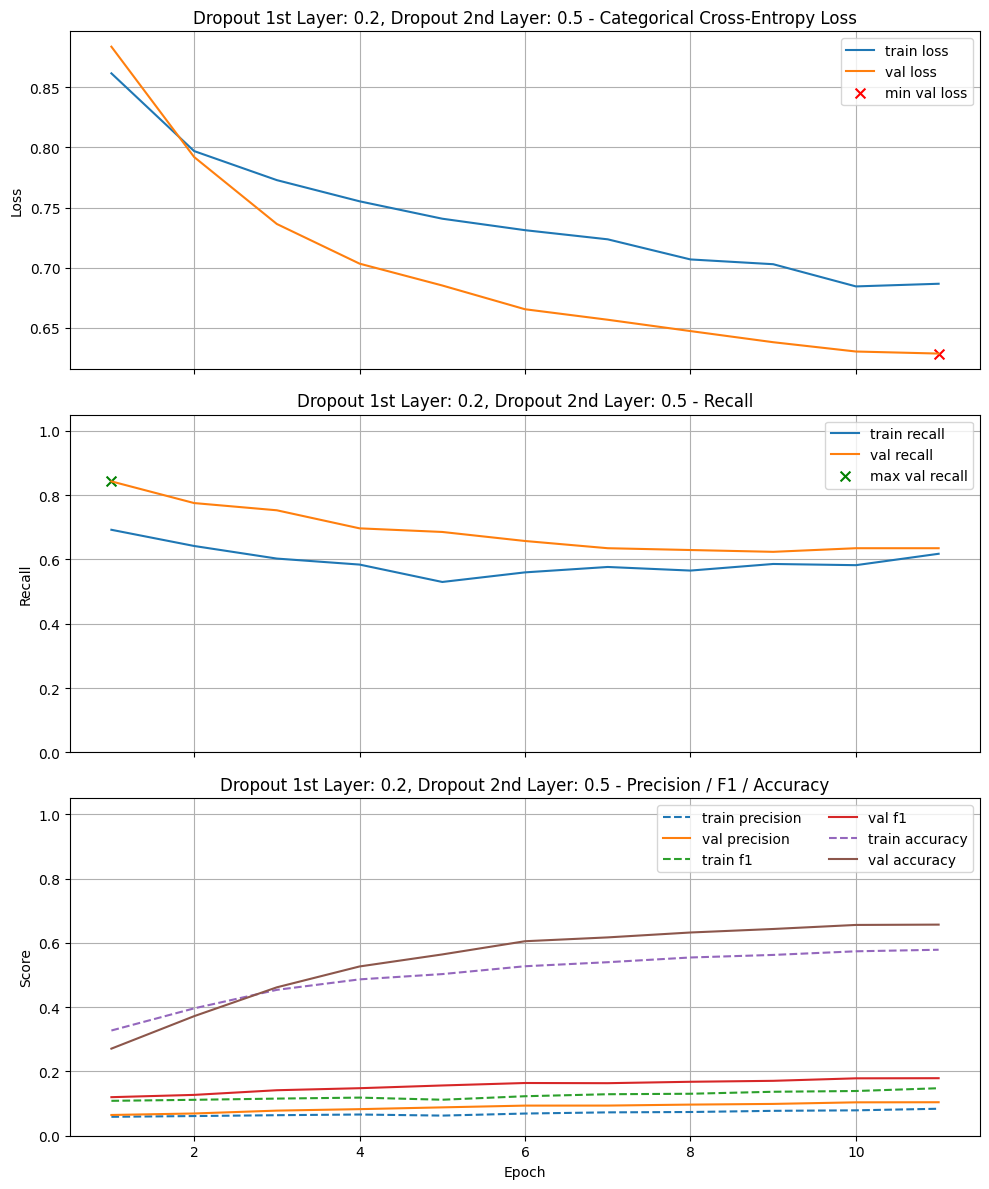


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step


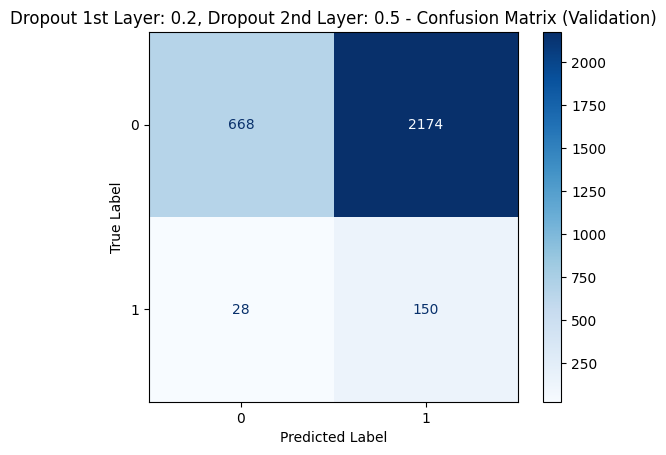

Final Training Metrics -> Loss: 0.6866, Precision: 0.0839, Recall: 0.6175, F1: 0.1477, Accuracy: 0.5785
Final Validation Metrics -> Loss: 0.6285, Precision: 0.1041, Recall: 0.6348, F1: 0.1789, Accuracy: 0.6566
Minimum Validation Loss: 0.6285 (Epoch 11)
Validation Metrics @ Min Loss -> Precision: 0.1041, Recall: 0.6348, F1: 0.1789, Accuracy: 0.6566
Best Validation Recall: 0.8427 (Epoch 1)
Best Validation Precision: 0.1041 (Epoch 11)
Best Validation F1: 0.1789 (Epoch 11)
Best Validation Accuracy: 0.6566 (Epoch 11)

Test Metrics -> Loss: 0.8819, Precision: 0.0579, Recall: 0.7416, F1: 0.1074, Accuracy: 0.2732

Validation-Test Gap -> Recall: 0.101124, Precision: 0.046278, F1: 0.071578, Accuracy: 0.383444

Execution Time: 00:00:03


In [16]:
# Your code here. Add as many cells as you need.
lr = 1e-4

drop_out_1st_layer = [0.0, 0.1, 0.2]
drop_out_2nd_layer = [0.3, 0.4, 0.5]

results_3 = pd.DataFrame(columns=[
    'Title',
    'Best Val Recall',
    'Best Val Precision',
    'Best Val F1',
    'Best Val Accuracy',
    'Min Val Loss',
    'Val Recall @ Min Loss',
    'Val Precision @ Min Loss',
    'Val F1 @ Min Loss',
    'Test Recall',
    'Test Precision',
    'Test F1',
    'Test Accuracy'
], index=[0,1,2,3,4,5,6,7,8])

for i, drop_out_1st in enumerate(drop_out_1st_layer):
    for j, drop_out_2nd in enumerate(drop_out_2nd_layer):
        model = build_model(X_train.shape[1], [ (64, af, 0.0, drop_out_1st), (32, af , 0.0, drop_out_2nd)], n_classes)
        history, metrics = train_and_test(model, lr_schedule=lr, title=f"Dropout 1st Layer: {drop_out_1st}, Dropout 2nd Layer: {drop_out_2nd}", verbose=0, return_history = True)
        results_3.iloc[i * 3 + j] = [
            f"Dropout 1st Layer: {drop_out_1st}, Dropout 2nd Layer: {drop_out_2nd}",
            metrics['best_val_recall'],
            metrics['best_val_precision'],
            metrics['best_val_f1'],
            metrics['best_val_accuracy'],
            metrics['min_val_loss'],
            metrics['val_recall_at_min_loss'],
            metrics['val_precision_at_min_loss'],
            metrics['val_f1_at_min_loss'],
            metrics['test_recall'],
            metrics['test_precision'],
            metrics['test_f1'],
            metrics['test_accuracy']
        ]

In [17]:
results_3

,Title,Best Val Recall,Best Val Precision,Best Val F1,Best Val Accuracy,Min Val Loss,Val Recall @ Min Loss,Val Precision @ Min Loss,Val F1 @ Min Loss,Test Recall,Test Precision,Test F1,Test Accuracy
0,"Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.3",0.651685,0.095745,0.165391,0.639073,0.589536,0.606742,0.095745,0.165391,0.685393,0.057574,0.106226,0.320199
1,"Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.4",0.702247,0.126819,0.214035,0.703311,0.516119,0.685393,0.125773,0.212544,0.707865,0.115702,0.198895,0.663907
2,"Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.5",0.769663,0.108247,0.187779,0.642053,0.616825,0.707865,0.108247,0.187779,0.741573,0.058955,0.109226,0.287086
3,"Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.3",0.735955,0.138264,0.232223,0.71755,0.519436,0.724719,0.138264,0.232223,0.657303,0.110586,0.18932,0.668212
4,"Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.4",0.735955,0.120259,0.206513,0.760265,0.533885,0.202247,0.058252,0.090452,0.758427,0.111478,0.194384,0.62947
5,"Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.5",0.865169,0.092224,0.158879,0.642384,0.619803,0.573034,0.092224,0.158879,0.938202,0.059388,0.111706,0.12053
6,"Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.3",0.730337,0.126368,0.214708,0.692384,0.519014,0.713483,0.126368,0.214708,0.735955,0.11552,0.199695,0.652318
7,"Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.4",0.764045,0.120253,0.207165,0.662914,0.532074,0.747191,0.120253,0.207165,0.820225,0.120363,0.209921,0.636093
8,"Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.5",0.842697,0.104147,0.178939,0.656623,0.628486,0.634831,0.104147,0.178939,0.741573,0.057869,0.107361,0.273179


In [18]:
# Combine all results
results_all = pd.concat([results_1, results_2, results_3], axis=0).reset_index(drop=True)
results_all

,Title,Best Val Recall,Best Val Precision,Best Val F1,Best Val Accuracy,Min Val Loss,Val Recall @ Min Loss,Val Precision @ Min Loss,Val F1 @ Min Loss,Test Recall,Test Precision,Test F1,Test Accuracy
0,Activation Function: relu,0.797753,0.14717,0.240493,0.820199,0.377783,0.398876,0.140039,0.207299,0.825843,0.120295,0.21,0.633775
1,Activation Function: tanh,0.792135,0.139966,0.219008,0.799669,0.403174,0.466292,0.139966,0.215305,0.820225,0.125862,0.218236,0.653642
2,Activation Function: sigmoid,0.876405,0.142145,0.235808,0.758278,0.391348,0.606742,0.140625,0.22833,0.893258,0.128954,0.225372,0.638079
3,Learning Rate: 0.001,0.724719,0.152057,0.240586,0.812252,0.394327,0.477528,0.152057,0.230665,0.741573,0.103529,0.181693,0.606291
4,Learning Rate: 0.0005,0.752809,0.151198,0.238771,0.822848,0.387274,0.410112,0.145129,0.214391,0.780899,0.121716,0.210606,0.654967
5,Learning Rate: 0.0001,0.724719,0.15879,0.239814,0.821523,0.405692,0.449438,0.141844,0.215633,0.747191,0.134073,0.22735,0.700662
6,Learning Rate: 5e-05,0.814607,0.157983,0.246296,0.806291,0.391121,0.52809,0.157983,0.243208,0.764045,0.098266,0.174136,0.572848
7,Learning Rate: 1e-05,0.775281,0.167728,0.243451,0.837417,0.36372,0.426966,0.150794,0.222874,0.758427,0.12772,0.218623,0.680464
8,"Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.3",0.651685,0.095745,0.165391,0.639073,0.589536,0.606742,0.095745,0.165391,0.685393,0.057574,0.106226,0.320199
9,"Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.4",0.702247,0.126819,0.214035,0.703311,0.516119,0.685393,0.125773,0.212544,0.707865,0.115702,0.198895,0.663907
